In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Non-noncyclic Stocks

### Kweichow Moutai Co.,Ltd.

In [5]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


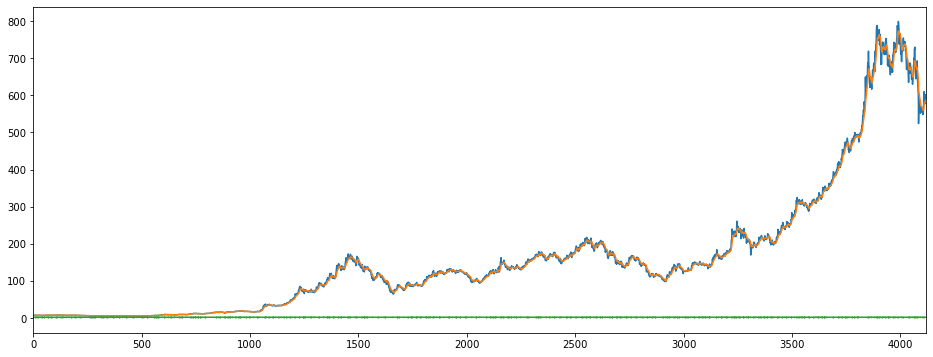

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2001-09-14,7.142585,7.257483,-41.873824,204624213.0,2.0
2001-09-17,7.224180,7.252359,-51.296847,208479649.0,2.0
2001-09-18,7.132634,7.233940,-72.964156,203965392.0,2.0
2001-09-19,7.214230,7.230908,-59.609037,209378730.0,2.0
2001-09-20,7.347568,7.248855,-37.785092,213725440.0,2.0


In [8]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4096, 25, 1)

In [10]:
price_data = np.array(price_data)
price_data.shape

(4096, 25, 1)

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4096, 25, 1)

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4096, 25, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4096, 64, 64, 1)

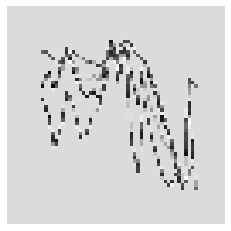

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.428571428571429, 1: 7.47945205479452, 2: 0.36607442172309757}
Epoch 1/200
 1/26 [>.............................] - ETA: 0s - loss: 0.4206 - accuracy: 0.6562 - mse: 5.5939 - weighted_accuracy: 0.3598 - weighted_mse: 5.5606WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 1s 30ms/step - loss: 0.2362 - accuracy: 0.3336 - mse: 1.5656 - weighted_accuracy: 0.3278 - weighted_mse: 1.5853 - val_loss: 0.2049 - val_accuracy: 0.0329 - val_mse: 1.1443 - val_weighted_accuracy: 0.0329 - val_weighted_mse: 1.1443
Epoch 2/200
26/26 [==============================] - 0s 12ms/step - loss: 0.2077 - accuracy: 0.2637 - mse: 1.2292 - weighted_accuracy: 0.3198 - weighted_mse: 1.2125 - val_loss: 0.2091 - val_accuracy: 0.0439 - va

Epoch 27/200
26/26 [==============================] - 0s 13ms/step - loss: 0.2004 - accuracy: 0.3147 - mse: 1.1848 - weighted_accuracy: 0.3812 - weighted_mse: 1.1608 - val_loss: 0.1962 - val_accuracy: 0.1207 - val_mse: 1.1437 - val_weighted_accuracy: 0.1207 - val_weighted_mse: 1.1437
Epoch 28/200
26/26 [==============================] - 0s 18ms/step - loss: 0.1991 - accuracy: 0.2949 - mse: 1.2134 - weighted_accuracy: 0.3739 - weighted_mse: 1.2090 - val_loss: 0.2007 - val_accuracy: 0.0780 - val_mse: 0.9884 - val_weighted_accuracy: 0.0780 - val_weighted_mse: 0.9884
Epoch 29/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1998 - accuracy: 0.2973 - mse: 1.1222 - weighted_accuracy: 0.3662 - weighted_mse: 1.1425 - val_loss: 0.2011 - val_accuracy: 0.0500 - val_mse: 1.0209 - val_weighted_accuracy: 0.0500 - val_weighted_mse: 1.0209
Epoch 30/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1997 - accuracy: 0.3117 - mse: 1.1598 - weighted_accuracy: 0.3628 - 

Epoch 56/200
26/26 [==============================] - 0s 13ms/step - loss: 0.1863 - accuracy: 0.2341 - mse: 1.2148 - weighted_accuracy: 0.4709 - weighted_mse: 1.1873 - val_loss: 0.1929 - val_accuracy: 0.0659 - val_mse: 1.0505 - val_weighted_accuracy: 0.0659 - val_weighted_mse: 1.0505
Epoch 57/200
26/26 [==============================] - 0s 13ms/step - loss: 0.1891 - accuracy: 0.2201 - mse: 1.2139 - weighted_accuracy: 0.4288 - weighted_mse: 1.1834 - val_loss: 0.1971 - val_accuracy: 0.0671 - val_mse: 0.9846 - val_weighted_accuracy: 0.0671 - val_weighted_mse: 0.9846
Epoch 58/200
26/26 [==============================] - 0s 13ms/step - loss: 0.1870 - accuracy: 0.2161 - mse: 1.1972 - weighted_accuracy: 0.4534 - weighted_mse: 1.1743 - val_loss: 0.1976 - val_accuracy: 0.0671 - val_mse: 0.9854 - val_weighted_accuracy: 0.0671 - val_weighted_mse: 0.9854
Epoch 59/200
26/26 [==============================] - 0s 13ms/step - loss: 0.1864 - accuracy: 0.2009 - mse: 1.2182 - weighted_accuracy: 0.4824 - 

Epoch 85/200
26/26 [==============================] - 0s 18ms/step - loss: 0.1646 - accuracy: 0.1911 - mse: 1.2952 - weighted_accuracy: 0.5696 - weighted_mse: 1.2813 - val_loss: 0.1968 - val_accuracy: 0.1988 - val_mse: 1.1332 - val_weighted_accuracy: 0.1988 - val_weighted_mse: 1.1332
Epoch 86/200
26/26 [==============================] - 0s 18ms/step - loss: 0.1633 - accuracy: 0.1987 - mse: 1.3246 - weighted_accuracy: 0.5638 - weighted_mse: 1.2770 - val_loss: 0.1947 - val_accuracy: 0.2329 - val_mse: 1.1844 - val_weighted_accuracy: 0.2329 - val_weighted_mse: 1.1844
Epoch 87/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1618 - accuracy: 0.1996 - mse: 1.3351 - weighted_accuracy: 0.5814 - weighted_mse: 1.2966 - val_loss: 0.1964 - val_accuracy: 0.2244 - val_mse: 1.1449 - val_weighted_accuracy: 0.2244 - val_weighted_mse: 1.1449
Epoch 88/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1608 - accuracy: 0.1951 - mse: 1.3487 - weighted_accuracy: 0.5906 - 

Epoch 114/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1458 - accuracy: 0.2817 - mse: 1.4952 - weighted_accuracy: 0.6505 - weighted_mse: 1.4868 - val_loss: 0.1880 - val_accuracy: 0.3390 - val_mse: 1.3281 - val_weighted_accuracy: 0.3390 - val_weighted_mse: 1.3281
Epoch 115/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1407 - accuracy: 0.2805 - mse: 1.5250 - weighted_accuracy: 0.6846 - weighted_mse: 1.5691 - val_loss: 0.1897 - val_accuracy: 0.3146 - val_mse: 1.2924 - val_weighted_accuracy: 0.3146 - val_weighted_mse: 1.2924
Epoch 116/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1429 - accuracy: 0.2784 - mse: 1.4872 - weighted_accuracy: 0.6449 - weighted_mse: 1.5658 - val_loss: 0.1877 - val_accuracy: 0.3390 - val_mse: 1.3413 - val_weighted_accuracy: 0.3390 - val_weighted_mse: 1.3413
Epoch 117/200
26/26 [==============================] - 0s 17ms/step - loss: 0.1392 - accuracy: 0.3046 - mse: 1.5775 - weighted_accuracy: 0.684

Epoch 143/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1244 - accuracy: 0.4353 - mse: 1.7917 - weighted_accuracy: 0.7500 - weighted_mse: 2.0850 - val_loss: 0.1725 - val_accuracy: 0.5012 - val_mse: 1.4686 - val_weighted_accuracy: 0.5012 - val_weighted_mse: 1.4686
Epoch 144/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1294 - accuracy: 0.4161 - mse: 1.7755 - weighted_accuracy: 0.7322 - weighted_mse: 2.0462 - val_loss: 0.1729 - val_accuracy: 0.5049 - val_mse: 1.5220 - val_weighted_accuracy: 0.5049 - val_weighted_mse: 1.5220
Epoch 145/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1214 - accuracy: 0.4359 - mse: 1.8458 - weighted_accuracy: 0.7567 - weighted_mse: 2.1748 - val_loss: 0.1756 - val_accuracy: 0.4780 - val_mse: 1.5062 - val_weighted_accuracy: 0.4780 - val_weighted_mse: 1.5062
Epoch 146/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1280 - accuracy: 0.4344 - mse: 1.7598 - weighted_accuracy: 0.738

Epoch 172/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1082 - accuracy: 0.5794 - mse: 2.1738 - weighted_accuracy: 0.7963 - weighted_mse: 2.9246 - val_loss: 0.1447 - val_accuracy: 0.6878 - val_mse: 1.8067 - val_weighted_accuracy: 0.6878 - val_weighted_mse: 1.8067
Epoch 173/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1076 - accuracy: 0.5910 - mse: 2.2023 - weighted_accuracy: 0.8135 - weighted_mse: 2.8443 - val_loss: 0.1493 - val_accuracy: 0.6695 - val_mse: 1.7742 - val_weighted_accuracy: 0.6695 - val_weighted_mse: 1.7742
Epoch 174/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1110 - accuracy: 0.5650 - mse: 2.1225 - weighted_accuracy: 0.8040 - weighted_mse: 2.7620 - val_loss: 0.1393 - val_accuracy: 0.7256 - val_mse: 1.7485 - val_weighted_accuracy: 0.7256 - val_weighted_mse: 1.7485
Epoch 175/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1078 - accuracy: 0.5830 - mse: 2.2089 - weighted_accuracy: 0.808

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11961047351360321
Test accuracy: 0.7914634346961975


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.070563   -1.8800002  -0.08725947]
 [-1.8824738  -1.1750166  -0.02896659]
 [-1.3609936  -0.909396   -0.2281723 ]
 ...
 [-1.9729339  -1.2495968  -0.01598543]
 [-0.9915819  -1.8500684  -0.13993964]
 [-3.2291083   0.19149531 -0.8353249 ]]


Counter({2: 708, 0: 55, 1: 57})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 747, 1: 36, 0: 37})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 820
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 32
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 33
actual holds but predicted buy: 51
actual holds but predicted sell: 53
actual predicted holds: 643
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 5.405405405405405%
Percentage holds correct: 86.07764390896921%
actual buys: 36
actual sells: 37
actual holds: 747


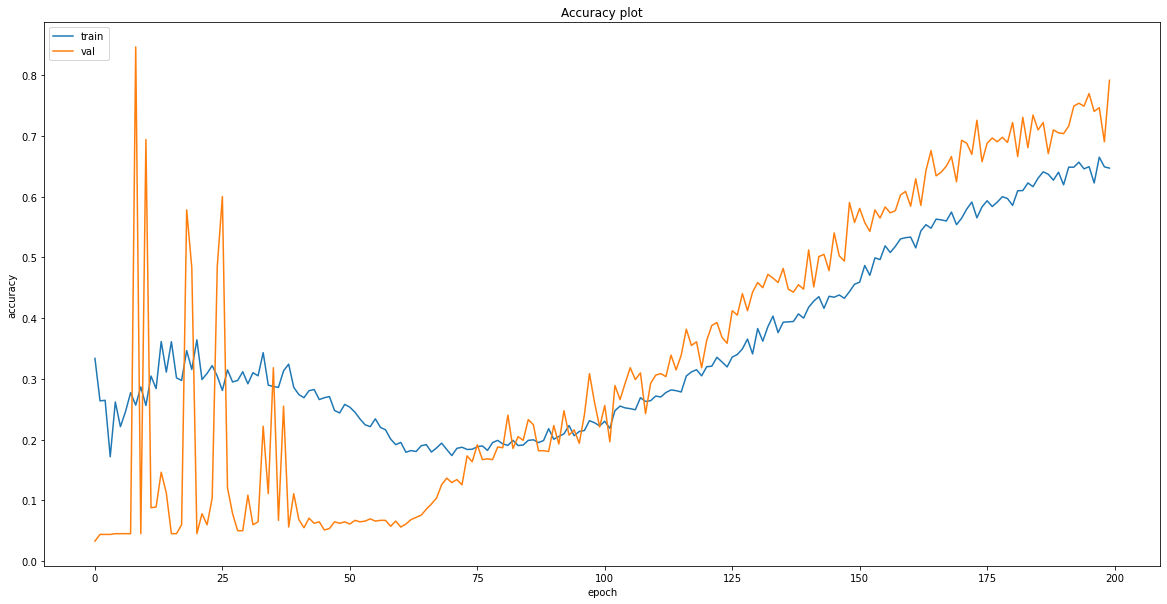

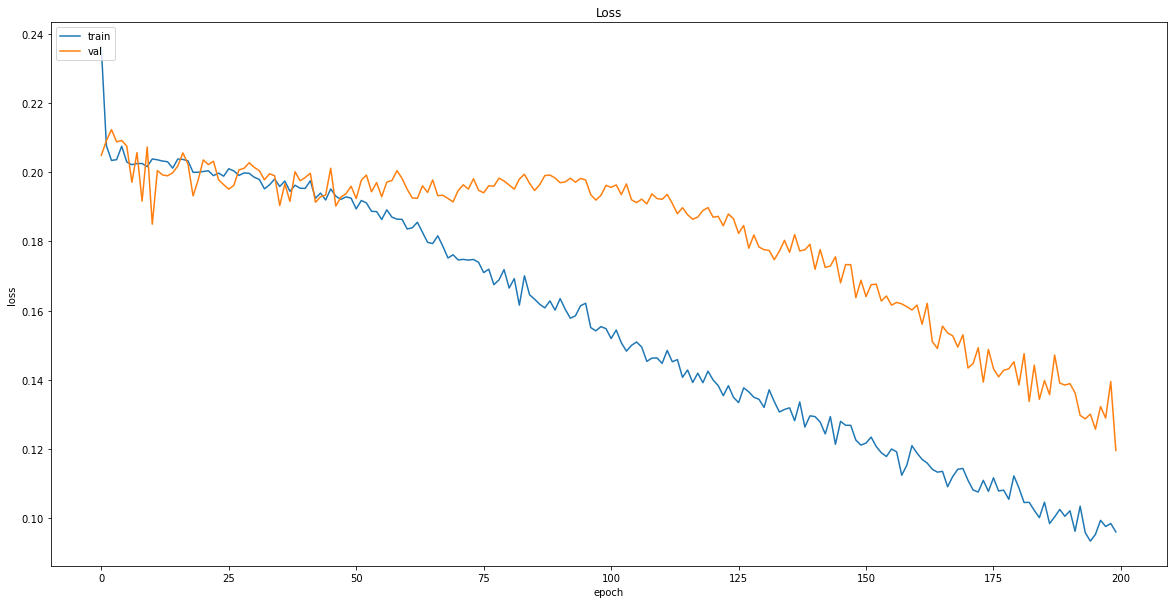

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('moutai_image_cnn_buy_hold_sell_25.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_image_cnn_buy_hold_sell_25.model\assets


### Test Performance

### non-recession

In [28]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


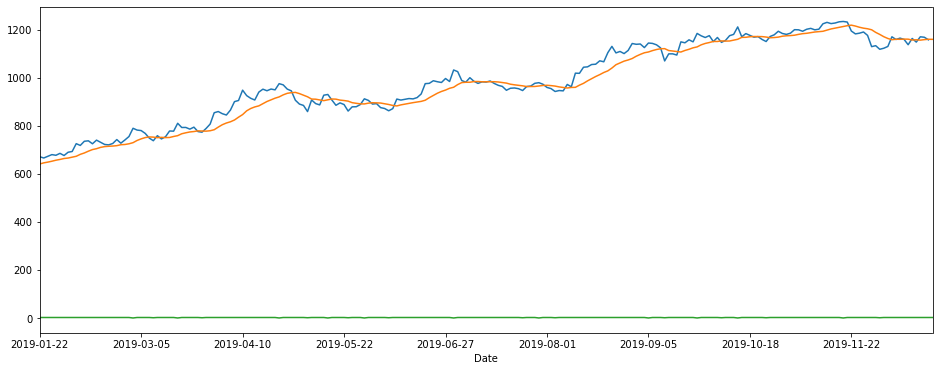

In [29]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [30]:
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
df2.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


In [31]:
df2 = df2.iloc[-10:]
df2.head(20)

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-06,610.099976,577.824500,-9.014119,1.233718e+09,2.0
2018-12-07,591.799988,579.974575,-34.788750,1.229942e+09,2.0
2018-12-10,587.000000,581.055409,-41.549296,1.227258e+09,2.0
2018-12-11,577.229980,580.466882,-55.309887,1.224794e+09,2.0
2018-12-12,582.989990,580.855052,-47.197197,1.226426e+09,2.0
2018-12-13,589.000000,582.108121,-38.732394,1.228418e+09,2.0
2018-12-14,601.750000,585.129949,-20.774648,1.232458e+09,2.0
2018-12-17,592.960022,586.334575,-33.154899,1.230002e+09,2.0
2018-12-18,590.520020,586.978490,-36.591522,1.227513e+09,2.0


In [32]:
df2 = pd.concat([df2,df])
df2.head(20)

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-06,610.099976,577.824500,-9.014119,1.233718e+09,2.0
2018-12-07,591.799988,579.974575,-34.788750,1.229942e+09,2.0
2018-12-10,587.000000,581.055409,-41.549296,1.227258e+09,2.0
2018-12-11,577.229980,580.466882,-55.309887,1.224794e+09,2.0
2018-12-12,582.989990,580.855052,-47.197197,1.226426e+09,2.0
2018-12-13,589.000000,582.108121,-38.732394,1.228418e+09,2.0
2018-12-14,601.750000,585.129949,-20.774648,1.232458e+09,2.0
2018-12-17,592.960022,586.334575,-33.154899,1.230002e+09,2.0
2018-12-18,590.520020,586.978490,-36.591522,1.227513e+09,2.0


In [33]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1

In [34]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [36]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [37]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [38]:
model = tf.keras.models.load_model("models/moutai_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 9ms/step - loss: 0.1203 - accuracy: 0.7971 - mean_squared_error: 2.1097 - weighted_accuracy: 0.7971 - weighted_mean_squared_error: 2.1097
Test loss: 0.12030553817749023
Test accuracy: 0.7971014380455017


In [39]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 181, 1: 16, 0: 10})

In [40]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [41]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-41-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-41-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-41-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,740.00000,704.389763,-23.444619,43919901.0,2.0,2,2
2019-02-19,730.76001,709.868261,-6.049880,47694490.0,2.0,2,2
2019-02-20,722.00000,713.082376,-17.677836,44744340.0,2.0,2,2
2019-02-21,720.25000,714.454318,-29.824573,40956103.0,2.0,2,2
2019-02-22,726.01001,715.345962,-32.098776,37971063.0,2.0,2,2


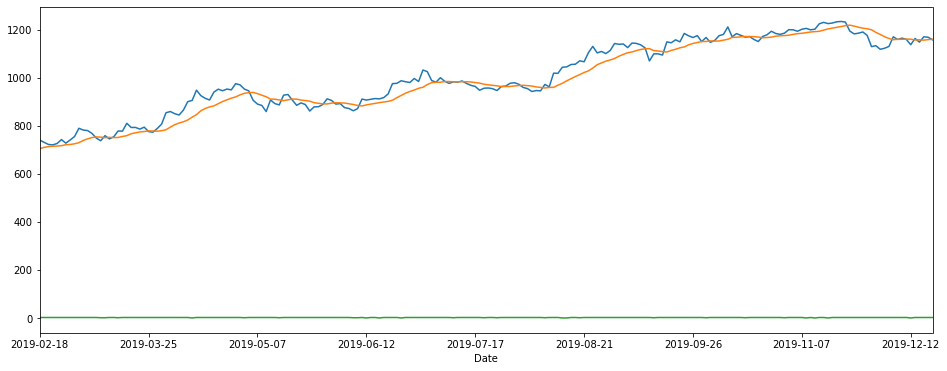

In [42]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

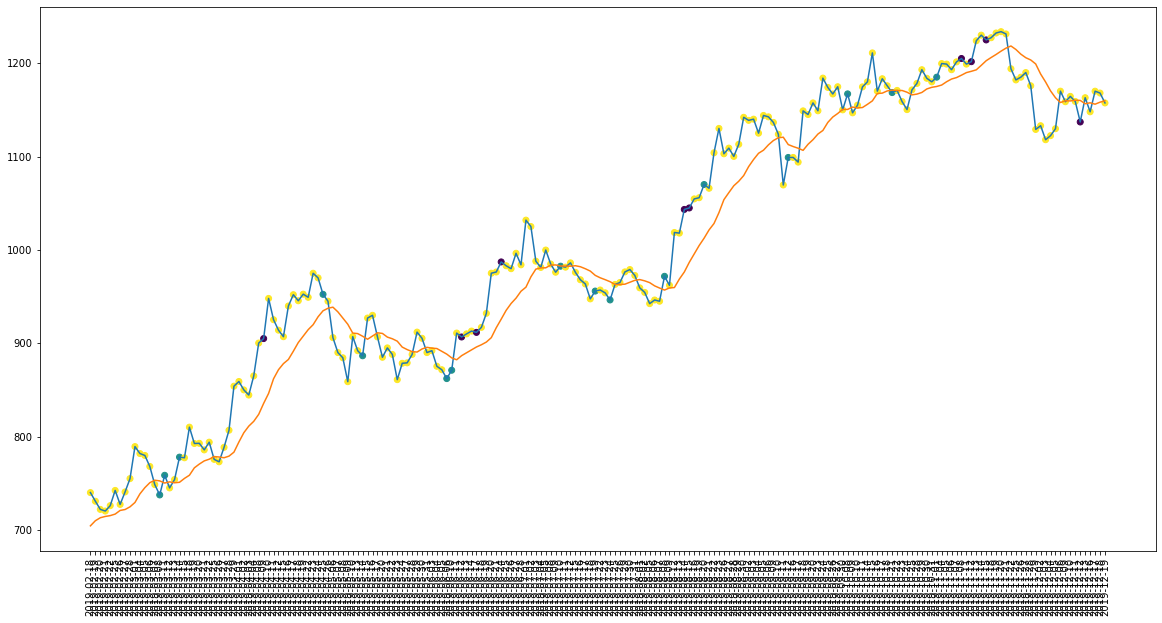

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

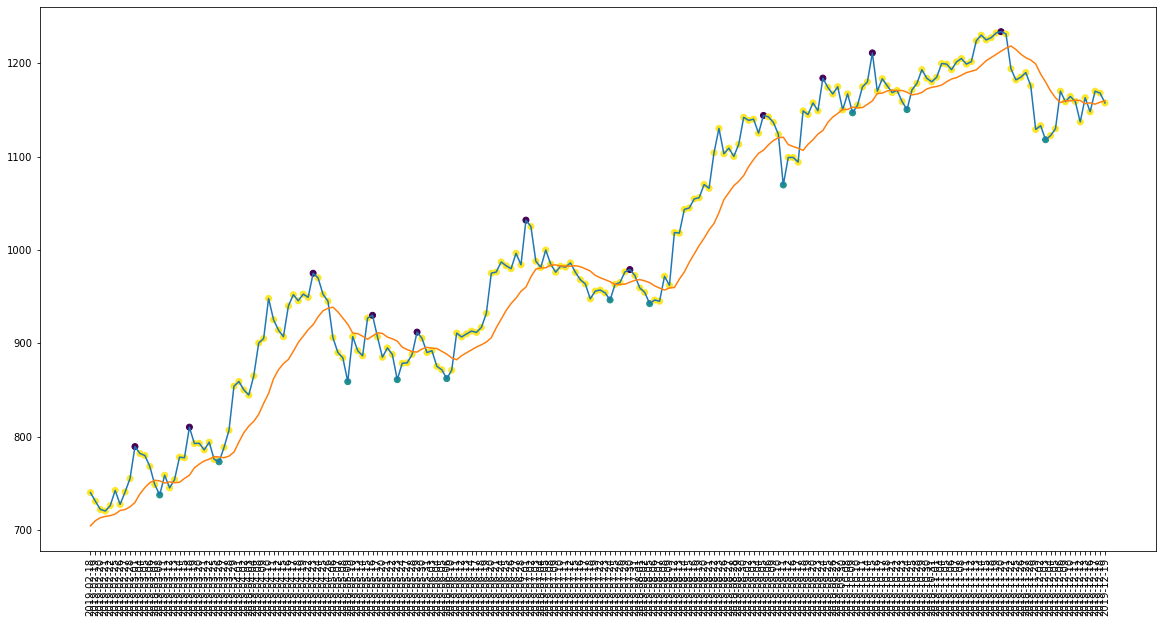

In [44]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [45]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 13
actual holds but predicted sell: 10
actual predicted holds: 162
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 0.0%
Percentage holds correct: 87.56756756756756%
actual buys: 11
actual sells: 11
actual holds: 185


In [46]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 56.25%
Percentage sells correct: 20.0%
Percentage holds correct: 85.55555555555556%


In [47]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $737.5
Shares owned at the moment: 13
Cash capital at the moment: $386.13437499999964


Price increase from previously bought: 22.375332243111103%
Share price: $905.0
Shares owned at the moment: 0
Cash capital at the moment: $12118.780625


Share price: $952.3699951171876
Shares owned at the moment: 12
Cash capital at the moment: $658.9124737548809


Stop Loss Activated!

Share price: $906.0
Shares owned at the moment: 0
Cash capital at the moment: $11501.01447375488


Share price: $886.5700073242188
Shares owned at the moment: 12
Cash capital at the moment: $832.9175756225559


Stop Loss Activated!

Share price: $861.0
Shares owned at the moment: 0
Cash capital at the moment: $11136.504575622555


Share price: $862.1300048828125
Shares owned at the moment: 12
Cash capital at the moment: $762.4942268676732


Price increase from previously bought: 5.448127958964344%
Share price: $911.5999755859376
Shares owned at the moment: 0
Cash capital at the moment: $11671.611134704588

In [48]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15358.36826651001
profit gained: 53.5836826651001%


### Recession

In [49]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


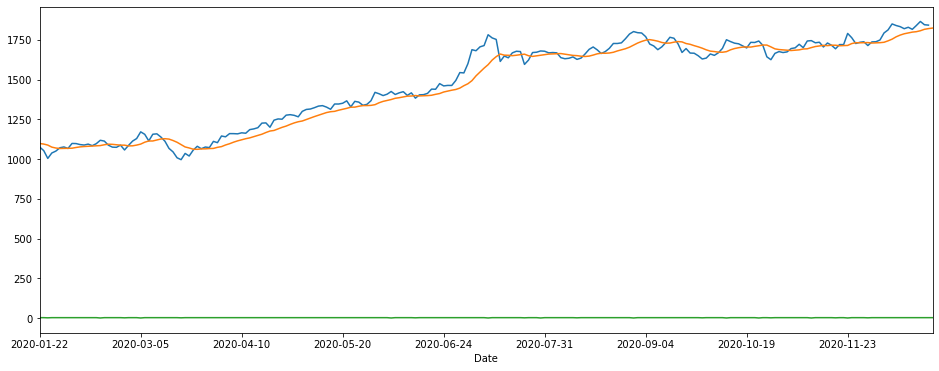

In [50]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [51]:
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])

In [52]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1

In [53]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [55]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [56]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [57]:
model = tf.keras.models.load_model("models/moutai_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 8ms/step - loss: 0.1228 - accuracy: 0.8077 - mean_squared_error: 2.0889 - weighted_accuracy: 0.8077 - weighted_mean_squared_error: 2.0889
Test loss: 0.12281923741102219
Test accuracy: 0.807692289352417


In [58]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 182, 1: 9, 0: 17})

In [59]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [60]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-60-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-60-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-60-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,2,2


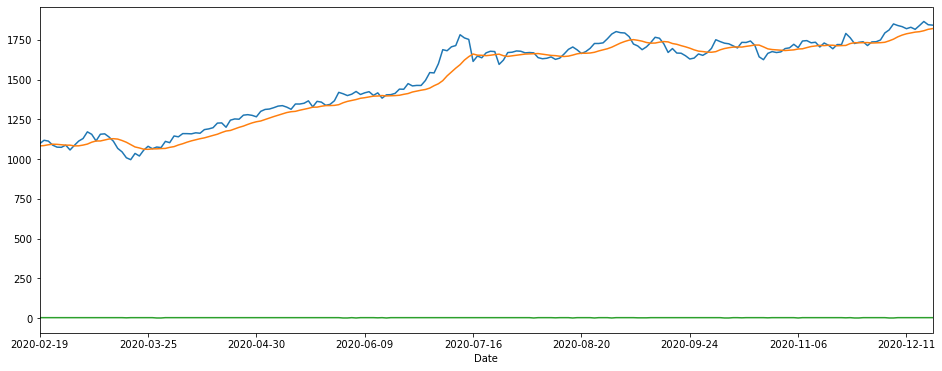

In [61]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

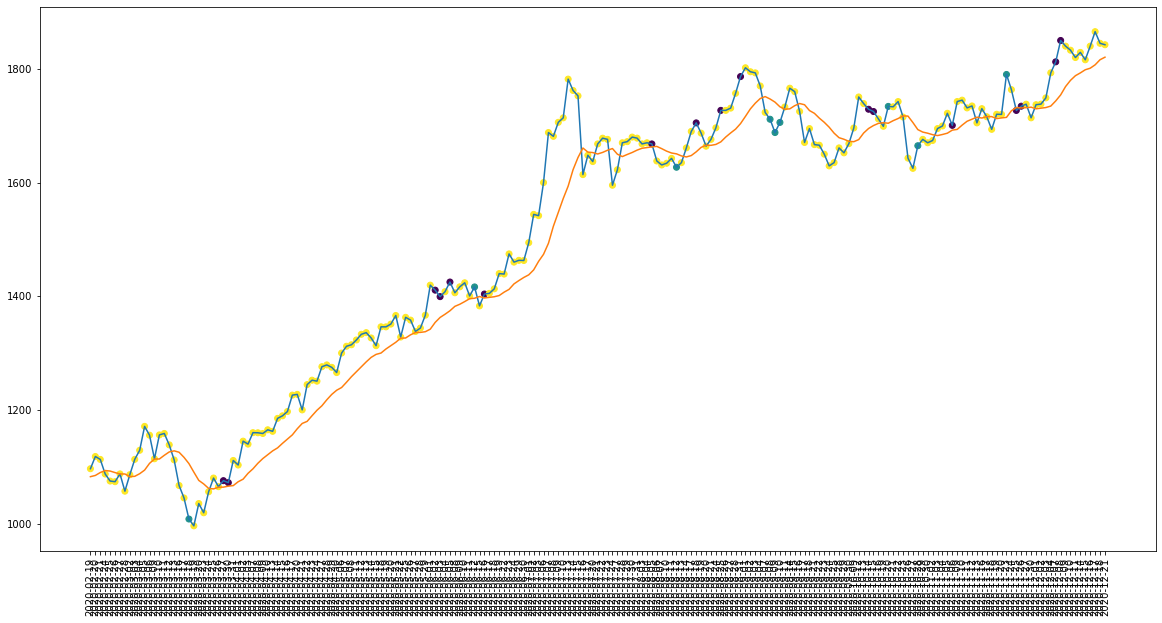

In [62]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

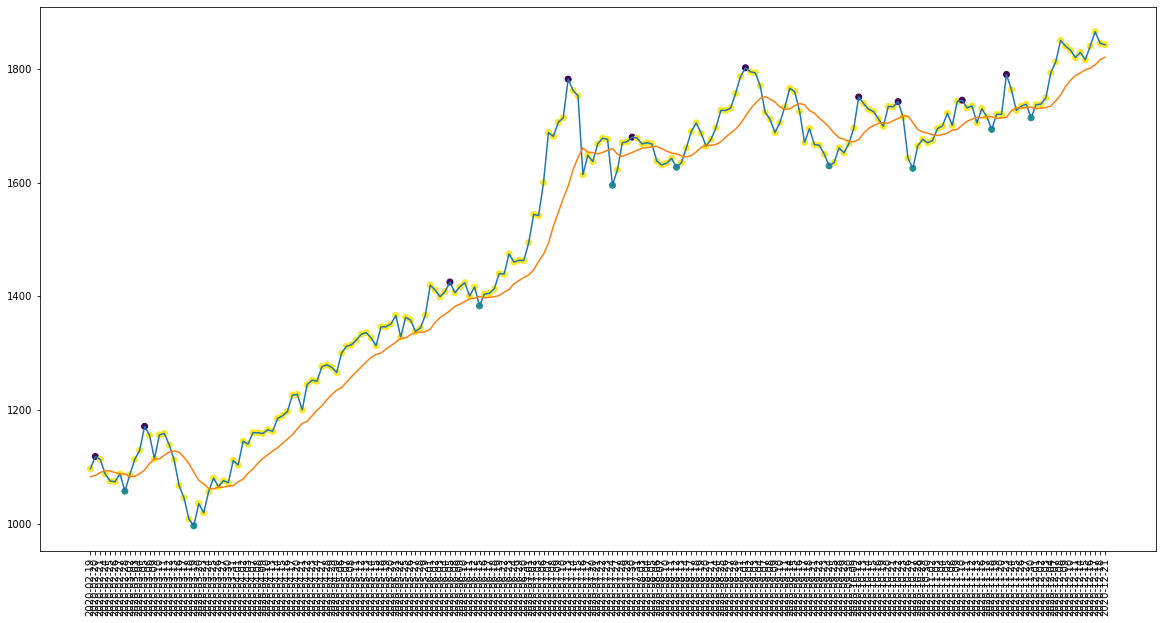

In [63]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [64]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 7
actual holds but predicted sell: 16
actual predicted holds: 166
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 10.0%
Percentage holds correct: 87.83068783068784%
actual buys: 9
actual sells: 10
actual holds: 189


In [65]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 47.05882352941177%
Percentage holds correct: 86.1878453038674%


In [66]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1007.989990234375
Shares owned at the moment: 9
Cash capital at the moment: $903.1423356323248


Price increase from previously bought: 6.404874706510233%
Share price: $1075.5
Shares owned at the moment: 0
Cash capital at the moment: $10556.023710632324


Share price: $1416.3699951171875
Shares owned at the moment: 7
Cash capital at the moment: $614.1686224060049


Price increase from previously bought: 17.442870534568033%
Share price: $1668.0
Shares owned at the moment: 0
Cash capital at the moment: $12258.059622406005


Share price: $1626.949951171875
Shares owned at the moment: 7
Cash capital at the moment: $838.0911776428202


Price increase from previously bought: 5.85843611103507%
Share price: $1727.0
Shares owned at the moment: 0
Cash capital at the moment: $12893.84642764282


Share price: $1711.4000244140625
Shares owned at the moment: 7
Cash capital at the moment: $881.1018062744115


Stop Loss Activated!

Share price: $1649.97998046875
Shares owned at the momen

In [67]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


### Midea Group

In [68]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


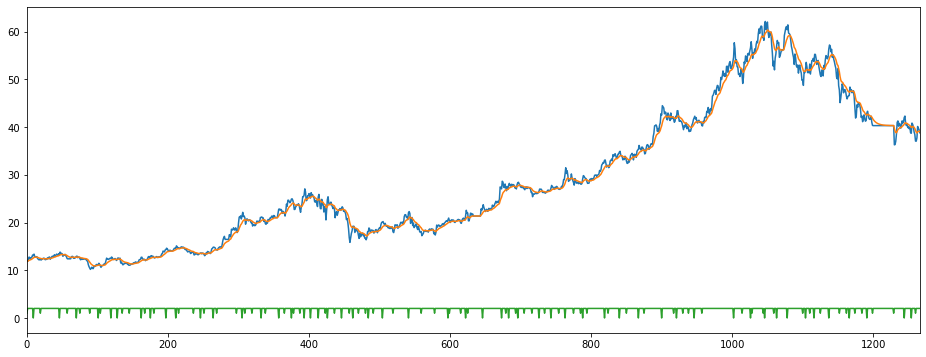

In [69]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [70]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [71]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [72]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1

In [73]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [75]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(1243, 64, 64, 1)

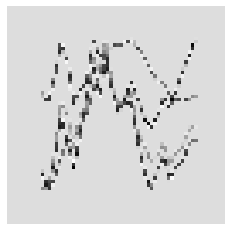

In [76]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [77]:
X = X/255

In [78]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [79]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [80]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [82]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 0 2 2 2 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 0 2 2 2 2 2 2 2 2 2 2 0 2 1 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 0 2 2 0 2 2 2 2
 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 0 2 2 0 0 1 2 2 2 2 2 2 0 2 2
 1 1 2 1 2 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2
 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 

{0: 8.08130081300813, 1: 6.761904761904762, 2: 0.3665191740412979}
Epoch 1/200
8/8 [==============================] - 4s 480ms/step - loss: 0.3056 - accuracy: 0.4366 - mse: 2.8305 - weighted_accuracy: 0.3446 - weighted_mse: 2.9854 - val_loss: 0.2038 - val_accuracy: 0.2490 - val_mse: 0.9560 - val_weighted_accuracy: 0.2490 - val_weighted_mse: 0.9560
Epoch 2/200
8/8 [==============================] - 0s 15ms/step - loss: 0.2321 - accuracy: 0.4256 - mse: 1.1294 - weighted_accuracy: 0.3507 - weighted_mse: 1.1721 - val_loss: 0.1965 - val_accuracy: 0.1165 - val_mse: 1.0459 - val_weighted_accuracy: 0.1165 - val_weighted_mse: 1.0459
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.2065 - accuracy: 0.3521 - mse: 1.4569 - weighted_accuracy: 0.4130 - weighted_mse: 1.4285 - val_loss: 0.1952 - val_accuracy: 0.6104 - val_mse: 0.8481 - val_weighted_accuracy: 0.6104 - val_weighted_mse: 0.8481
Epoch 4/200
8/8 [==============================] - 0s 15ms/step - loss: 0.2152 - accur

Epoch 29/200
8/8 [==============================] - 0s 14ms/step - loss: 0.2037 - accuracy: 0.2254 - mse: 1.2808 - weighted_accuracy: 0.3213 - weighted_mse: 1.2650 - val_loss: 0.2056 - val_accuracy: 0.0482 - val_mse: 0.9343 - val_weighted_accuracy: 0.0482 - val_weighted_mse: 0.9343
Epoch 30/200
8/8 [==============================] - 0s 15ms/step - loss: 0.2023 - accuracy: 0.2374 - mse: 1.1225 - weighted_accuracy: 0.3851 - weighted_mse: 1.1089 - val_loss: 0.2041 - val_accuracy: 0.0442 - val_mse: 1.0122 - val_weighted_accuracy: 0.0442 - val_weighted_mse: 1.0122
Epoch 31/200
8/8 [==============================] - 0s 15ms/step - loss: 0.2012 - accuracy: 0.2243 - mse: 1.1672 - weighted_accuracy: 0.3659 - weighted_mse: 1.1554 - val_loss: 0.2040 - val_accuracy: 0.0482 - val_mse: 1.0045 - val_weighted_accuracy: 0.0482 - val_weighted_mse: 1.0045
Epoch 32/200
8/8 [==============================] - 0s 14ms/step - loss: 0.2020 - accuracy: 0.2274 - mse: 1.2228 - weighted_accuracy: 0.3621 - weighted

Epoch 58/200
8/8 [==============================] - 0s 16ms/step - loss: 0.2027 - accuracy: 0.2938 - mse: 1.2044 - weighted_accuracy: 0.3668 - weighted_mse: 1.1625 - val_loss: 0.2004 - val_accuracy: 0.0643 - val_mse: 0.9514 - val_weighted_accuracy: 0.0643 - val_weighted_mse: 0.9514
Epoch 59/200
8/8 [==============================] - 0s 17ms/step - loss: 0.1994 - accuracy: 0.2887 - mse: 1.1754 - weighted_accuracy: 0.3716 - weighted_mse: 1.1439 - val_loss: 0.1989 - val_accuracy: 0.0522 - val_mse: 1.0440 - val_weighted_accuracy: 0.0522 - val_weighted_mse: 1.0440
Epoch 60/200
8/8 [==============================] - 0s 17ms/step - loss: 0.2037 - accuracy: 0.3571 - mse: 1.1342 - weighted_accuracy: 0.3321 - weighted_mse: 1.1458 - val_loss: 0.1928 - val_accuracy: 0.4378 - val_mse: 0.8781 - val_weighted_accuracy: 0.4378 - val_weighted_mse: 0.8781
Epoch 61/200
8/8 [==============================] - 0s 16ms/step - loss: 0.2004 - accuracy: 0.3099 - mse: 1.1678 - weighted_accuracy: 0.3134 - weighted

Epoch 87/200
8/8 [==============================] - 0s 17ms/step - loss: 0.1943 - accuracy: 0.2817 - mse: 1.1976 - weighted_accuracy: 0.4206 - weighted_mse: 1.2027 - val_loss: 0.2013 - val_accuracy: 0.0643 - val_mse: 0.9916 - val_weighted_accuracy: 0.0643 - val_weighted_mse: 0.9916
Epoch 88/200
8/8 [==============================] - 0s 16ms/step - loss: 0.1972 - accuracy: 0.1922 - mse: 1.1371 - weighted_accuracy: 0.4094 - weighted_mse: 1.1098 - val_loss: 0.1951 - val_accuracy: 0.0602 - val_mse: 1.0760 - val_weighted_accuracy: 0.0602 - val_weighted_mse: 1.0760
Epoch 89/200
8/8 [==============================] - 0s 16ms/step - loss: 0.1972 - accuracy: 0.2384 - mse: 1.2691 - weighted_accuracy: 0.3955 - weighted_mse: 1.2435 - val_loss: 0.1988 - val_accuracy: 0.0602 - val_mse: 0.9712 - val_weighted_accuracy: 0.0602 - val_weighted_mse: 0.9712
Epoch 90/200
8/8 [==============================] - 0s 16ms/step - loss: 0.1969 - accuracy: 0.3099 - mse: 1.0851 - weighted_accuracy: 0.4194 - weighted

Epoch 116/200
8/8 [==============================] - 0s 17ms/step - loss: 0.1915 - accuracy: 0.1901 - mse: 1.1681 - weighted_accuracy: 0.4437 - weighted_mse: 1.1442 - val_loss: 0.1976 - val_accuracy: 0.0643 - val_mse: 1.0385 - val_weighted_accuracy: 0.0643 - val_weighted_mse: 1.0385
Epoch 117/200
8/8 [==============================] - 0s 18ms/step - loss: 0.1937 - accuracy: 0.1901 - mse: 1.1631 - weighted_accuracy: 0.4102 - weighted_mse: 1.1377 - val_loss: 0.1992 - val_accuracy: 0.0683 - val_mse: 1.0496 - val_weighted_accuracy: 0.0683 - val_weighted_mse: 1.0496
Epoch 118/200
8/8 [==============================] - 0s 16ms/step - loss: 0.1890 - accuracy: 0.2596 - mse: 1.2065 - weighted_accuracy: 0.4434 - weighted_mse: 1.2285 - val_loss: 0.1881 - val_accuracy: 0.0602 - val_mse: 0.9391 - val_weighted_accuracy: 0.0602 - val_weighted_mse: 0.9391
Epoch 119/200
8/8 [==============================] - 0s 15ms/step - loss: 0.1825 - accuracy: 0.3078 - mse: 1.1636 - weighted_accuracy: 0.5050 - weig

Epoch 145/200
8/8 [==============================] - 0s 17ms/step - loss: 0.1678 - accuracy: 0.2445 - mse: 1.2248 - weighted_accuracy: 0.6108 - weighted_mse: 1.2333 - val_loss: 0.1921 - val_accuracy: 0.0803 - val_mse: 1.0152 - val_weighted_accuracy: 0.0803 - val_weighted_mse: 1.0152
Epoch 146/200
8/8 [==============================] - 0s 15ms/step - loss: 0.1758 - accuracy: 0.2213 - mse: 1.3394 - weighted_accuracy: 0.5573 - weighted_mse: 1.3232 - val_loss: 0.1929 - val_accuracy: 0.0884 - val_mse: 1.0697 - val_weighted_accuracy: 0.0884 - val_weighted_mse: 1.0697
Epoch 147/200
8/8 [==============================] - 0s 16ms/step - loss: 0.1705 - accuracy: 0.1821 - mse: 1.1895 - weighted_accuracy: 0.5609 - weighted_mse: 1.2230 - val_loss: 0.1974 - val_accuracy: 0.0763 - val_mse: 0.9706 - val_weighted_accuracy: 0.0763 - val_weighted_mse: 0.9706
Epoch 148/200
8/8 [==============================] - 0s 15ms/step - loss: 0.1736 - accuracy: 0.1922 - mse: 1.2026 - weighted_accuracy: 0.5622 - weig

Epoch 174/200
8/8 [==============================] - 0s 18ms/step - loss: 0.1658 - accuracy: 0.2203 - mse: 1.2302 - weighted_accuracy: 0.5816 - weighted_mse: 1.2635 - val_loss: 0.1947 - val_accuracy: 0.2129 - val_mse: 1.0272 - val_weighted_accuracy: 0.2129 - val_weighted_mse: 1.0272
Epoch 175/200
8/8 [==============================] - 0s 19ms/step - loss: 0.1606 - accuracy: 0.2243 - mse: 1.3023 - weighted_accuracy: 0.5686 - weighted_mse: 1.3675 - val_loss: 0.1904 - val_accuracy: 0.3052 - val_mse: 1.0370 - val_weighted_accuracy: 0.3052 - val_weighted_mse: 1.0370
Epoch 176/200
8/8 [==============================] - 0s 17ms/step - loss: 0.1575 - accuracy: 0.2384 - mse: 1.2740 - weighted_accuracy: 0.6126 - weighted_mse: 1.3587 - val_loss: 0.1918 - val_accuracy: 0.2209 - val_mse: 1.0776 - val_weighted_accuracy: 0.2209 - val_weighted_mse: 1.0776
Epoch 177/200
8/8 [==============================] - 0s 16ms/step - loss: 0.1575 - accuracy: 0.2384 - mse: 1.3324 - weighted_accuracy: 0.5869 - weig

In [83]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18372675776481628
Test accuracy: 0.3734939694404602


In [84]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.2552217  -0.22005722 -0.5442815 ]
 [-0.18182912 -1.2523537  -0.78852487]
 [-0.3079813  -0.8788493  -0.5715063 ]
 [-0.42015052 -0.76216954 -0.5224107 ]
 [-0.5041176  -0.64073545 -0.4739686 ]
 [-1.2971926  -0.36070323 -0.51507795]
 [-1.0380299  -0.38932666 -0.4168928 ]
 [-0.8246296  -0.5043869  -0.4511617 ]
 [-0.57150507 -0.5654668  -0.43855074]
 [-0.413871   -0.7656629  -0.5197843 ]
 [-1.1731995  -0.32451153 -0.5466023 ]
 [-0.16252875 -0.97600716 -0.6063435 ]
 [-0.90956885 -0.3879549  -0.4019277 ]
 [-1.1404992  -0.35701284 -0.46223244]
 [-0.28113222 -0.9016087  -0.5773978 ]
 [-0.12056137 -1.2885468  -0.7773774 ]
 [-0.7901363  -0.5290029  -0.45881885]
 [-0.7752472  -0.444202   -0.37922212]
 [-1.2029027  -0.2832385  -0.5066387 ]
 [-0.15807463 -1.2550614  -0.7897578 ]
 [-0.71671087 -0.5201905  -0.4121041 ]
 [-0.18296203 -1.0280529  -0.6395357 ]
 [-0.46717393 -0.67413384 -0.47432008]
 [-0.48292843 -0.753464   -0.5188657 ]
 [-0.80103403 -0.4988692  -0.45745727]
 [-0.8672386  -0.3488716 

Counter({1: 90, 0: 75, 2: 84})

In [85]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 226, 1: 12, 0: 11})

In [86]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 249
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 81
actual holds but predicted sell: 67
actual predicted holds: 78
Percentage buys correct: 58.333333333333336%
Percentage sells correct: 72.72727272727273%
Percentage holds correct: 34.51327433628319%
actual buys: 12
actual sells: 11
actual holds: 226


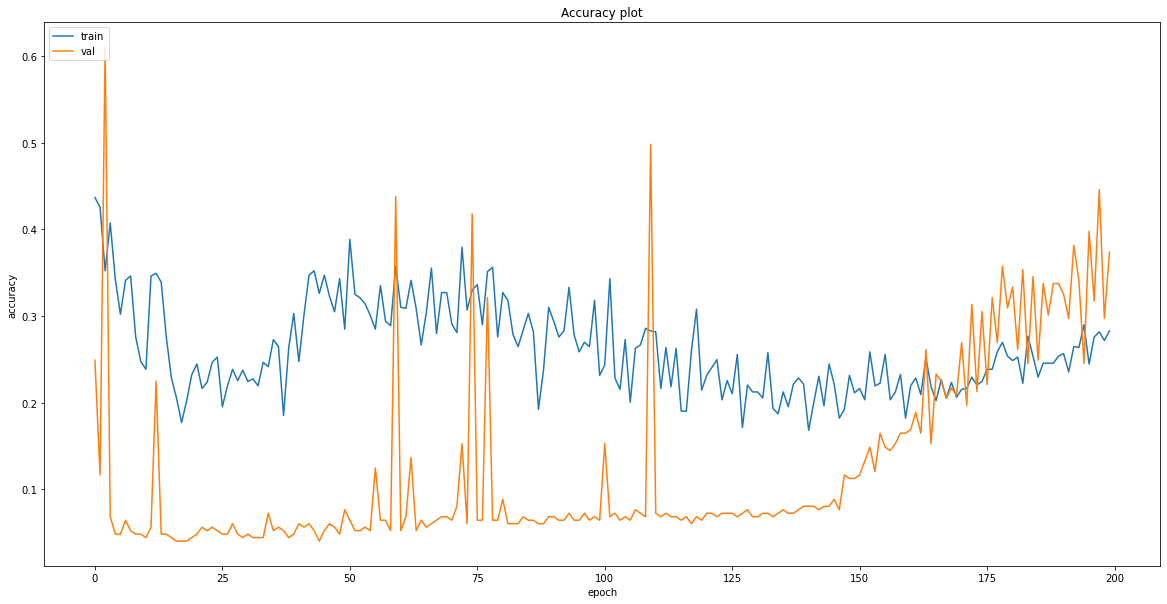

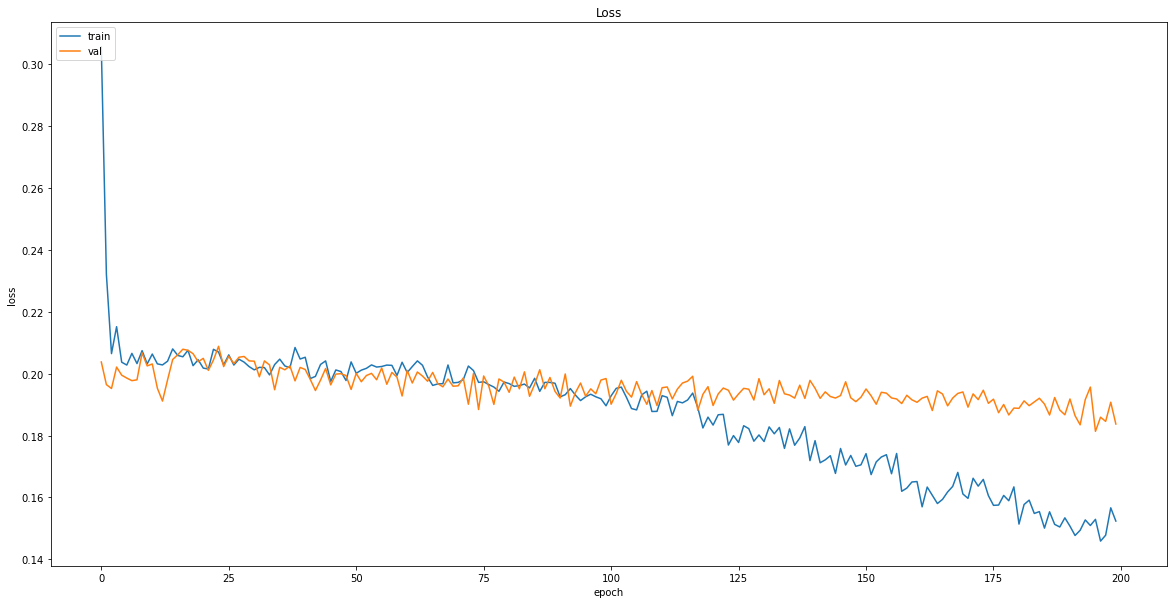

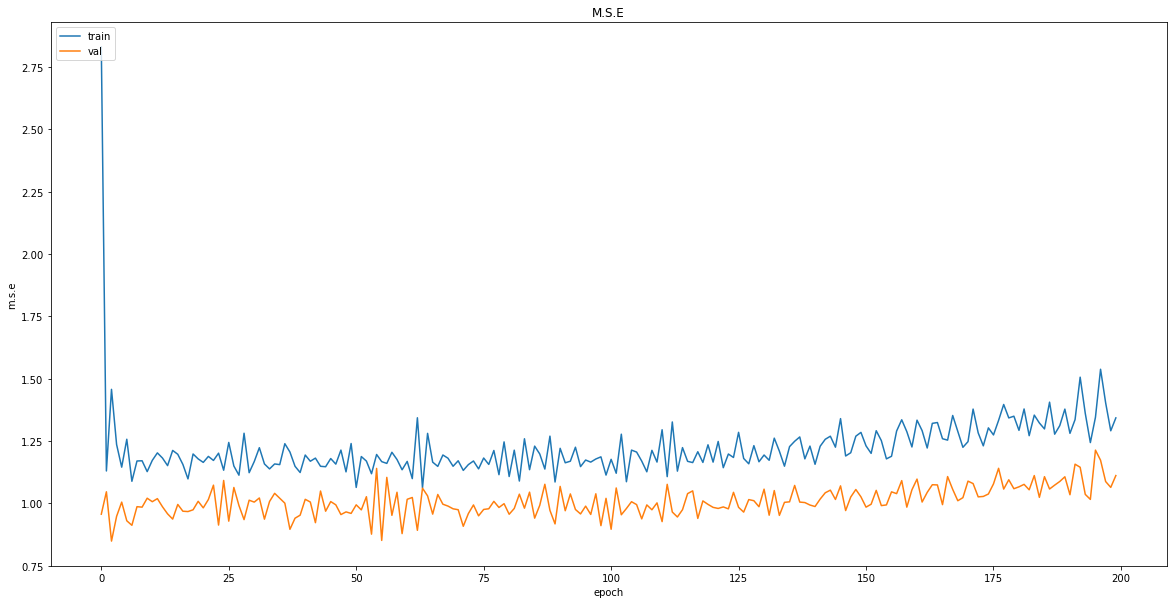

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [88]:
# Save model
model.save("models/{}".format('midea_image_cnn_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/midea_image_cnn_buy_hold_sell_25.model\assets


### Test Performance

#### Non-Recession

In [89]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0


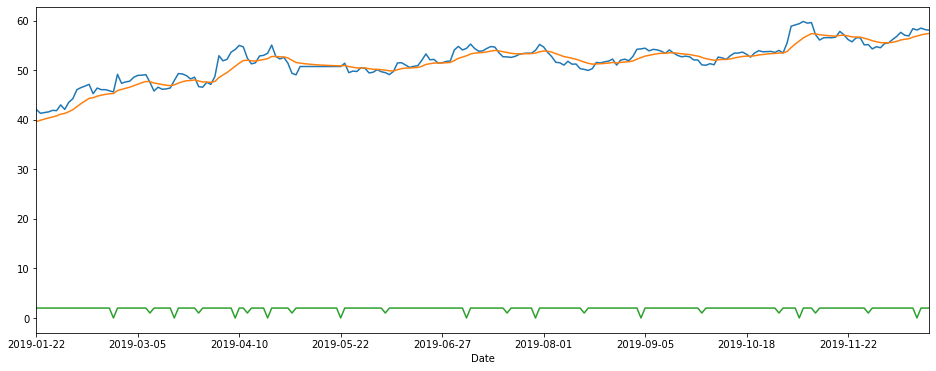

In [90]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [91]:
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])

In [92]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1
        
# willr_data = np.array(willr_data)
# price_data = np.array(price_data)
# ema_data = np.array(ema_data)
# obv_data = np.array(obv_data)

In [93]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [95]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [96]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [97]:
model = tf.keras.models.load_model("models/midea_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1878 - accuracy: 0.3478 - mean_squared_error: 1.1232 - weighted_accuracy: 0.3478 - weighted_mean_squared_error: 1.1232
Test loss: 0.18780294060707092
Test accuracy: 0.3478260934352875


In [98]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 71, 1: 70, 0: 66})

In [99]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [100]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-100-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-100-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-100-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,2,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,1,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,1,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,1,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,1,2


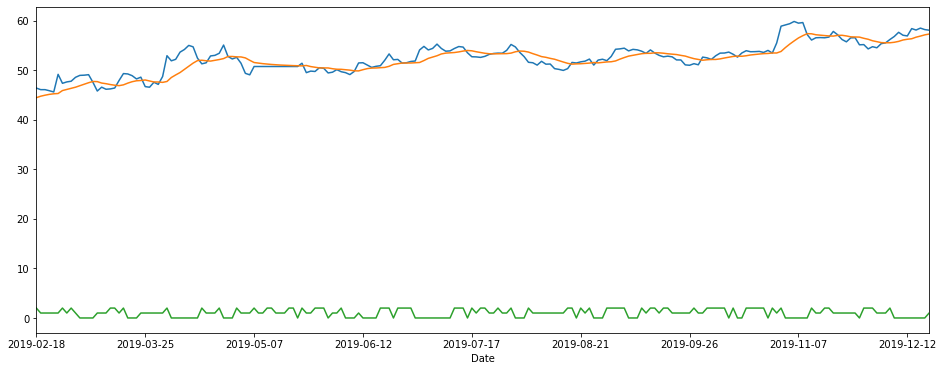

In [101]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

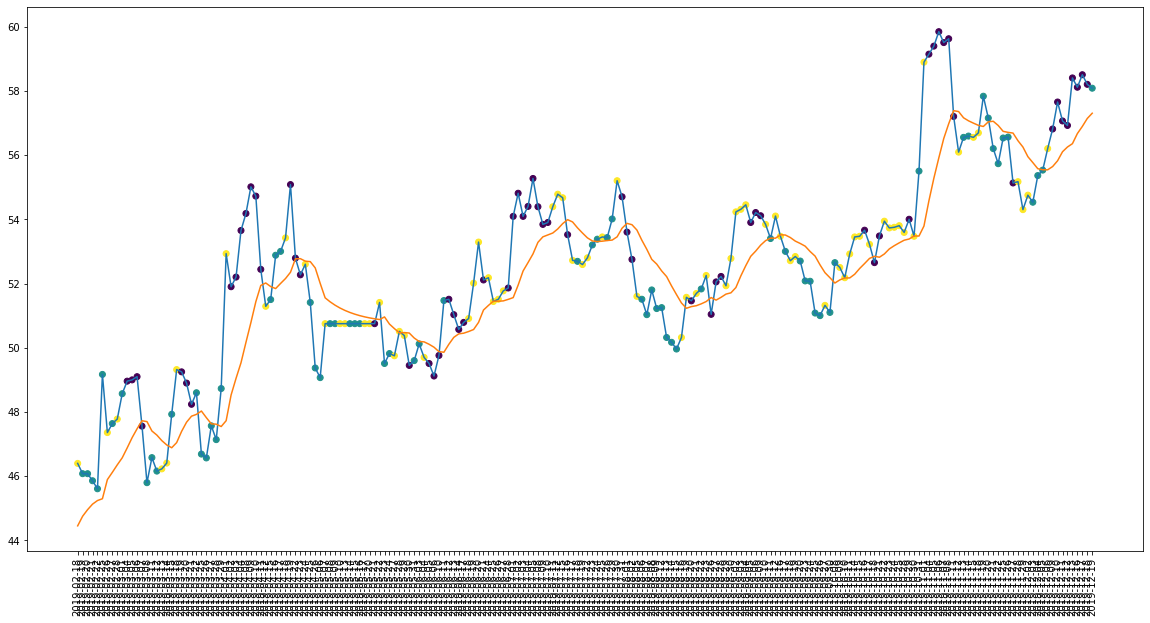

In [102]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

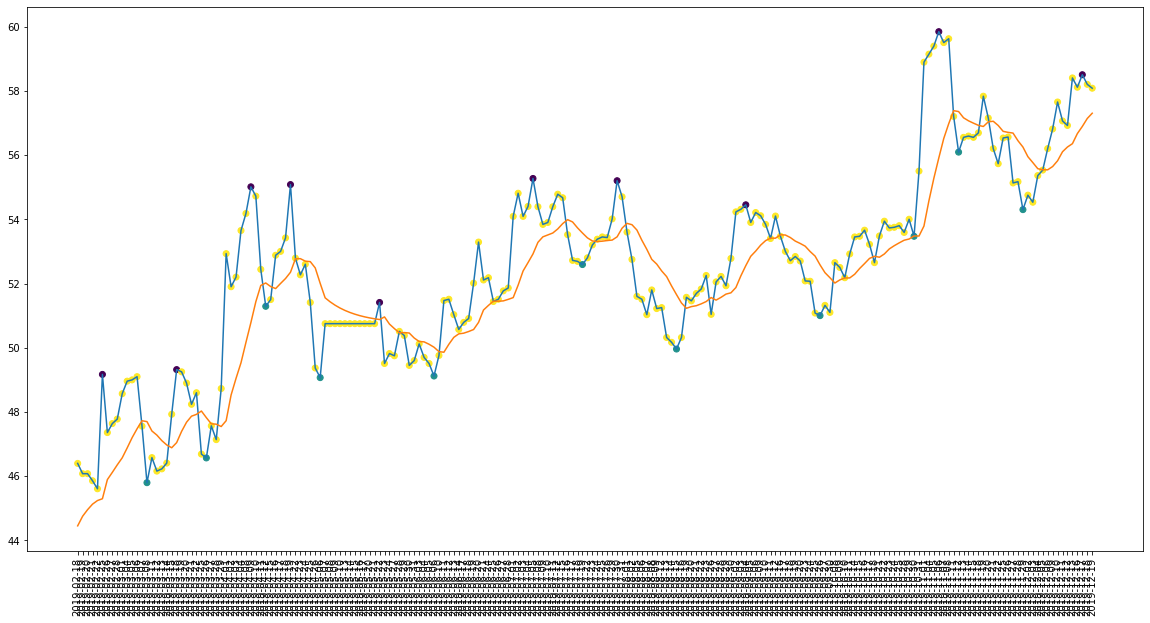

In [103]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [104]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 64
actual holds but predicted sell: 60
actual predicted holds: 62
Percentage buys correct: 45.45454545454545%
Percentage sells correct: 50.0%
Percentage holds correct: 33.333333333333336%
actual buys: 11
actual sells: 10
actual holds: 186


In [105]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 56.52173913043478%
Percentage sells correct: 50.0%
Percentage holds correct: 77.46478873239437%


In [106]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $46.08000183105469
Shares owned at the moment: 216
Cash capital at the moment: $19.348083404540375


Price increase from previously bought: 5.958607620227463%
Share price: $48.959999084472656
Shares owned at the moment: 0
Cash capital at the moment: $10565.625646194458


Share price: $45.79999923706055
Shares owned at the moment: 230
Cash capital at the moment: $2.6573221530907176


Price increase from previously bought: 7.237848798794122%
Share price: $49.25
Shares owned at the moment: 0
Cash capital at the moment: $11299.00669715309


Share price: $48.599998474121094
Shares owned at the moment: 231
Cash capital at the moment: $41.53390060043239


Stop Loss Activated!

Share price: $46.68999862670898
Shares owned at the moment: 0
Cash capital at the moment: $10797.263761742588


Share price: $46.68999862670898
Shares owned at the moment: 230
Cash capital at the moment: $29.032653468129865


Price increase from previously bought: 10.853864770599042%
Share price: $51.900001

In [107]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


#### Recession

In [108]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0


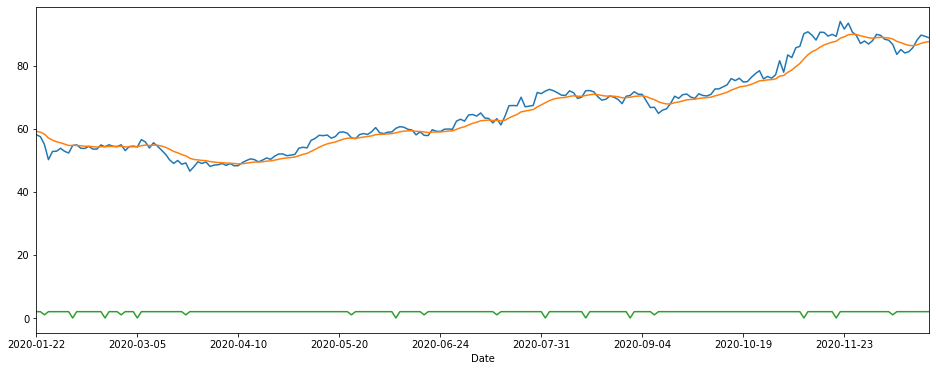

In [109]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [110]:
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-09,56.200001,55.641030,-41.801348,1.203534e+09,2.0
2019-12-10,56.810001,55.820872,-27.713568,1.224386e+09,2.0
2019-12-11,57.650002,56.102276,-5.476179,1.245103e+09,2.0
2019-12-12,57.060001,56.249619,-19.523799,1.231138e+09,2.0
2019-12-13,56.919998,56.352754,-22.857208,1.218430e+09,2.0


In [111]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [112]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [113]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [114]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [115]:
model = tf.keras.models.load_model("models/midea_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1864 - accuracy: 0.3894 - mean_squared_error: 1.1122 - weighted_accuracy: 0.3894 - weighted_mean_squared_error: 1.1122
Test loss: 0.18637515604496002
Test accuracy: 0.38942307233810425


In [116]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 67, 1: 66, 2: 75})

In [117]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [118]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-118-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-118-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-118-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,0,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,0,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,0,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,0,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,1,2


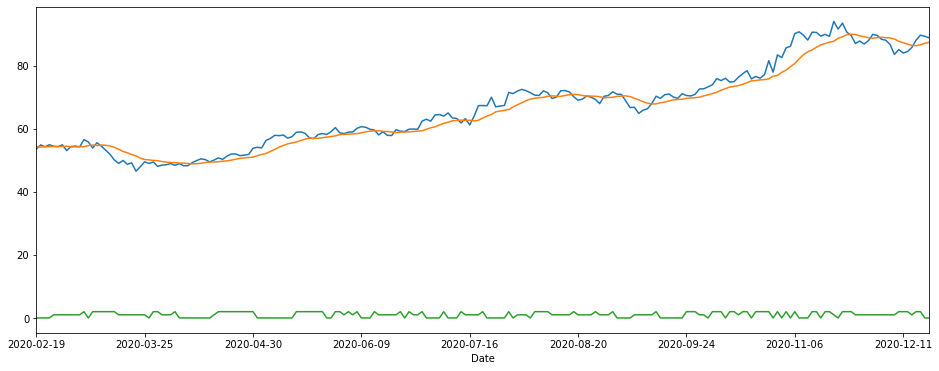

In [119]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

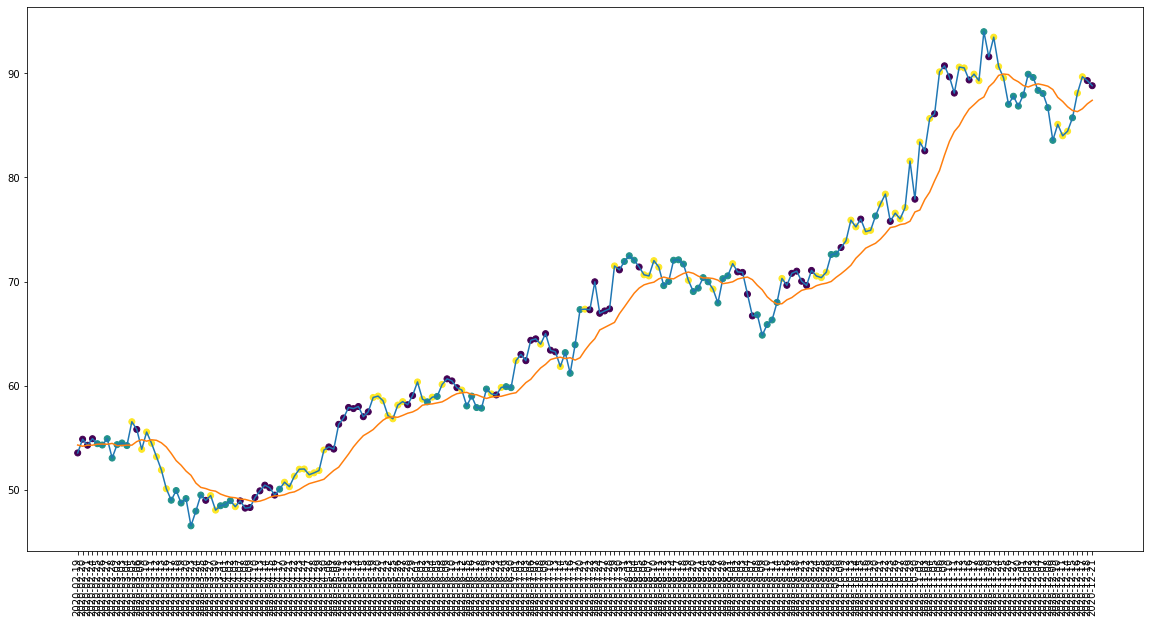

In [120]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

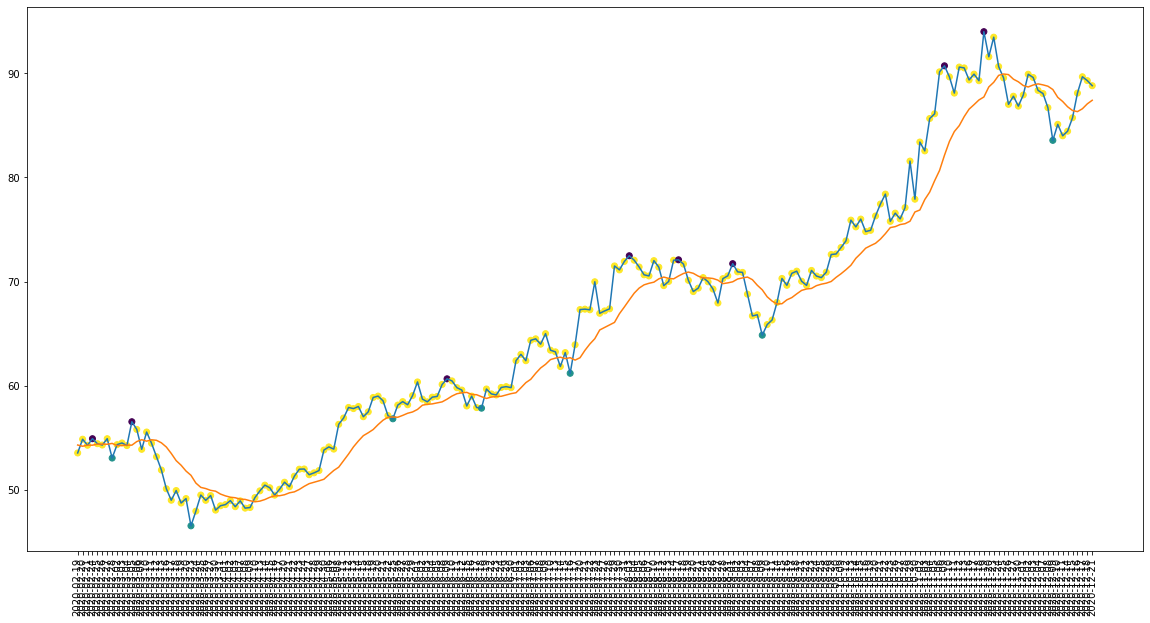

In [121]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [122]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 2
actual holds but predicted buy: 57
actual holds but predicted sell: 64
actual predicted holds: 72
Percentage buys correct: 85.71428571428571%
Percentage sells correct: 37.5%
Percentage holds correct: 37.30569948186528%
actual buys: 7
actual sells: 8
actual holds: 193


In [123]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 50.0%
Percentage sells correct: 46.96969696969697%
Percentage holds correct: 89.33333333333333%


In [124]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $54.43000030517578
Shares owned at the moment: 183
Cash capital at the moment: $11.918046499251432


Stop Loss Activated!

Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9483.49964996719


Share price: $49.0
Shares owned at the moment: 193
Cash capital at the moment: $0.49289996719016926


Stop Loss Activated!

Share price: $46.540000915527344
Shares owned at the moment: 0
Cash capital at the moment: $8958.011971178052


Share price: $46.540000915527344
Shares owned at the moment: 191
Cash capital at the moment: $44.42666083144832


Price increase from previously bought: 5.5541552790387305%
Share price: $49.2599983215332
Shares owned at the moment: 0
Cash capital at the moment: $9427.212526125904


Share price: $50.06000137329102
Shares owned at the moment: 187
Cash capital at the moment: $40.24891361426671


Price increase from previously bought: 7.8137746989152435%
Share price: $54.11999893188477
Shares owned at the moment: 0
Ca

In [125]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


## Walmart

In [126]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


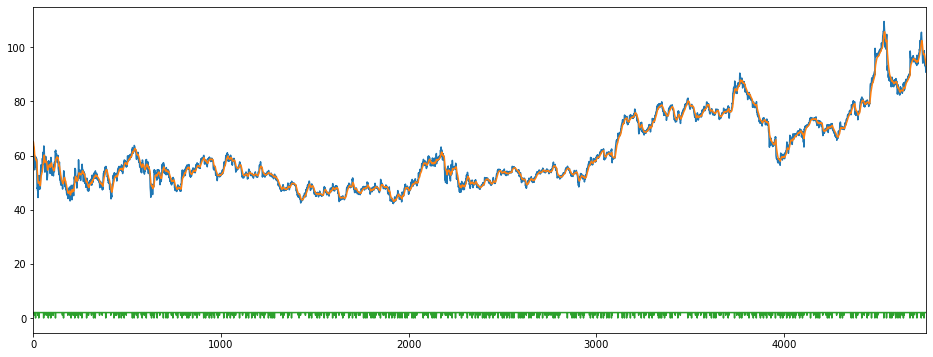

In [127]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [128]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,63.3750,65.176128,-85.271318,-26649200.0,2.0
2000-01-24,62.4375,64.754801,-94.594595,-33601700.0,2.0
2000-01-25,59.3750,63.927139,-83.606557,-41401600.0,2.0
2000-01-26,61.1250,63.496041,-68.306011,-34997800.0,2.0
2000-01-27,61.9375,63.256265,-61.202186,-30459400.0,2.0


In [129]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1

In [130]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [132]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4735, 64, 64, 1)

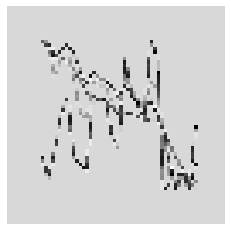

In [133]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [134]:
X = X/255

In [135]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [136]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [137]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [138]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [139]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.133709981167608, 1: 7.341085271317829, 2: 0.36716099641368616}
Epoch 1/200
30/30 [==============================] - 2s 72ms/step - loss: 0.2468 - accuracy: 0.3606 - mse: 1.6013 - weighted_accuracy: 0.3380 - weighted_mse: 1.6840 - val_loss: 0.2006 - val_accuracy: 0.2302 - val_mse: 0.9188 - val_weighted_accuracy: 0.2302 - val_weighted_mse: 0.9188
Epoch 2/200
30/30 [==============================] - 0s 12ms/step - loss: 0.2044 - accuracy: 0.3440 - mse: 1.2003 - weighted_accuracy: 0.3398 - weighted_mse: 1.1975 - val_loss: 0.1981 - val_accuracy: 0.3749 - val_mse: 0.9265 - val_weighted_accuracy: 0.3749 - val_weighted_mse: 0.9265
Epoch 3/200
30/30 [==============================] - 0s 16ms/step - loss: 0.2042 - accuracy: 0.3577 - mse: 1.1652 - weighted_accuracy: 0.3439 - weighted_mse: 1.1787 - val_loss: 0.2004 - val_accuracy: 0.0465 - val_mse: 0.9850 - val_weighted_accuracy: 0.0465 - val_weighted_mse: 0.9850
Epoch 4/200
30/30 [==============================] - 1s 21ms/step - loss: 0.204

Epoch 57/200
30/30 [==============================] - 1s 18ms/step - loss: 0.1859 - accuracy: 0.3023 - mse: 1.2297 - weighted_accuracy: 0.4701 - weighted_mse: 1.2149 - val_loss: 0.1924 - val_accuracy: 0.1679 - val_mse: 1.0032 - val_weighted_accuracy: 0.1679 - val_weighted_mse: 1.0032
Epoch 58/200
30/30 [==============================] - 1s 17ms/step - loss: 0.1875 - accuracy: 0.2574 - mse: 1.2218 - weighted_accuracy: 0.4361 - weighted_mse: 1.1982 - val_loss: 0.1852 - val_accuracy: 0.4266 - val_mse: 0.9944 - val_weighted_accuracy: 0.4266 - val_weighted_mse: 0.9944
Epoch 59/200
30/30 [==============================] - 1s 17ms/step - loss: 0.1853 - accuracy: 0.3244 - mse: 1.2244 - weighted_accuracy: 0.4837 - weighted_mse: 1.2050 - val_loss: 0.1850 - val_accuracy: 0.3115 - val_mse: 1.1021 - val_weighted_accuracy: 0.3115 - val_weighted_mse: 1.1021
Epoch 60/200
30/30 [==============================] - 1s 18ms/step - loss: 0.1850 - accuracy: 0.3078 - mse: 1.2638 - weighted_accuracy: 0.4525 - 

Epoch 86/200
30/30 [==============================] - 1s 22ms/step - loss: 0.1643 - accuracy: 0.3215 - mse: 1.2930 - weighted_accuracy: 0.5712 - weighted_mse: 1.2543 - val_loss: 0.1835 - val_accuracy: 0.3020 - val_mse: 1.1305 - val_weighted_accuracy: 0.3020 - val_weighted_mse: 1.1305
Epoch 87/200
30/30 [==============================] - 1s 22ms/step - loss: 0.1618 - accuracy: 0.3181 - mse: 1.3201 - weighted_accuracy: 0.5774 - weighted_mse: 1.3062 - val_loss: 0.1819 - val_accuracy: 0.3442 - val_mse: 1.1293 - val_weighted_accuracy: 0.3442 - val_weighted_mse: 1.1293
Epoch 88/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1623 - accuracy: 0.3168 - mse: 1.3196 - weighted_accuracy: 0.5711 - weighted_mse: 1.2637 - val_loss: 0.1832 - val_accuracy: 0.3305 - val_mse: 1.1224 - val_weighted_accuracy: 0.3305 - val_weighted_mse: 1.1224
Epoch 89/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1629 - accuracy: 0.3194 - mse: 1.3103 - weighted_accuracy: 0.5997 - 

Epoch 115/200
30/30 [==============================] - 1s 22ms/step - loss: 0.1356 - accuracy: 0.4604 - mse: 1.5976 - weighted_accuracy: 0.7028 - weighted_mse: 1.5951 - val_loss: 0.1649 - val_accuracy: 0.5533 - val_mse: 1.3812 - val_weighted_accuracy: 0.5533 - val_weighted_mse: 1.3812
Epoch 116/200
30/30 [==============================] - 1s 22ms/step - loss: 0.1316 - accuracy: 0.4644 - mse: 1.6777 - weighted_accuracy: 0.7005 - weighted_mse: 1.7393 - val_loss: 0.1616 - val_accuracy: 0.5861 - val_mse: 1.4056 - val_weighted_accuracy: 0.5861 - val_weighted_mse: 1.4056
Epoch 117/200
30/30 [==============================] - 1s 21ms/step - loss: 0.1304 - accuracy: 0.4760 - mse: 1.6973 - weighted_accuracy: 0.7009 - weighted_mse: 1.7268 - val_loss: 0.1678 - val_accuracy: 0.5195 - val_mse: 1.4616 - val_weighted_accuracy: 0.5195 - val_weighted_mse: 1.4616
Epoch 118/200
30/30 [==============================] - 1s 22ms/step - loss: 0.1311 - accuracy: 0.4826 - mse: 1.6577 - weighted_accuracy: 0.710

Epoch 144/200
30/30 [==============================] - 1s 21ms/step - loss: 0.1108 - accuracy: 0.6090 - mse: 2.0144 - weighted_accuracy: 0.7698 - weighted_mse: 2.2222 - val_loss: 0.1523 - val_accuracy: 0.6220 - val_mse: 1.6735 - val_weighted_accuracy: 0.6220 - val_weighted_mse: 1.6735
Epoch 145/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1116 - accuracy: 0.5887 - mse: 2.0107 - weighted_accuracy: 0.7356 - weighted_mse: 2.3090 - val_loss: 0.1439 - val_accuracy: 0.6790 - val_mse: 1.6107 - val_weighted_accuracy: 0.6790 - val_weighted_mse: 1.6107
Epoch 146/200
30/30 [==============================] - 1s 22ms/step - loss: 0.1095 - accuracy: 0.6019 - mse: 2.0730 - weighted_accuracy: 0.7656 - weighted_mse: 2.3302 - val_loss: 0.1403 - val_accuracy: 0.6948 - val_mse: 1.6391 - val_weighted_accuracy: 0.6948 - val_weighted_mse: 1.6391
Epoch 147/200
30/30 [==============================] - 1s 22ms/step - loss: 0.1071 - accuracy: 0.6032 - mse: 2.0814 - weighted_accuracy: 0.782

Epoch 173/200
30/30 [==============================] - 1s 23ms/step - loss: 0.0947 - accuracy: 0.6650 - mse: 2.3965 - weighted_accuracy: 0.7943 - weighted_mse: 2.8693 - val_loss: 0.1314 - val_accuracy: 0.7286 - val_mse: 1.9698 - val_weighted_accuracy: 0.7286 - val_weighted_mse: 1.9698
Epoch 174/200
30/30 [==============================] - 1s 23ms/step - loss: 0.0951 - accuracy: 0.6727 - mse: 2.4523 - weighted_accuracy: 0.8025 - weighted_mse: 2.8951 - val_loss: 0.1328 - val_accuracy: 0.7297 - val_mse: 1.7771 - val_weighted_accuracy: 0.7297 - val_weighted_mse: 1.7771
Epoch 175/200
30/30 [==============================] - 1s 22ms/step - loss: 0.0984 - accuracy: 0.6558 - mse: 2.4235 - weighted_accuracy: 0.7658 - weighted_mse: 2.9029 - val_loss: 0.1203 - val_accuracy: 0.7804 - val_mse: 1.8844 - val_weighted_accuracy: 0.7804 - val_weighted_mse: 1.8844
Epoch 176/200
30/30 [==============================] - 1s 22ms/step - loss: 0.0943 - accuracy: 0.6719 - mse: 2.4883 - weighted_accuracy: 0.795

In [140]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11457917094230652
Test accuracy: 0.8109820485115051


In [141]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.3419778  -1.0937437   0.0822824 ]
 [-2.6298978  -0.04161648 -0.6903864 ]
 [-1.4231086  -0.7008622  -0.15563855]
 ...
 [-1.7965227  -0.9801222   0.02241387]
 [-0.7977384  -1.9799585  -0.00668167]
 [-0.990777   -1.88337     0.14110246]]


Counter({2: 845, 1: 32, 0: 70})

In [142]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 860, 0: 44, 1: 43})

In [143]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 947
actual predicted buys: 1
actual buys but predicted sell: 2
actual buys but predicted hold: 40
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 41
actual holds but predicted buy: 31
actual holds but predicted sell: 65
actual predicted holds: 764
Percentage buys correct: 2.3255813953488373%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 88.83720930232558%
actual buys: 43
actual sells: 44
actual holds: 860


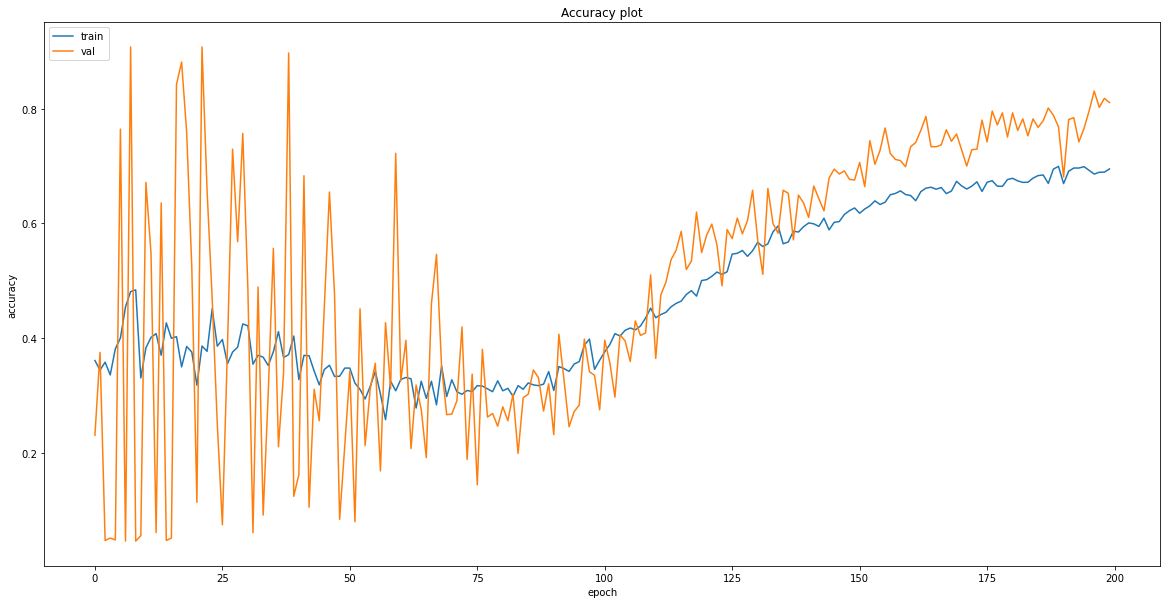

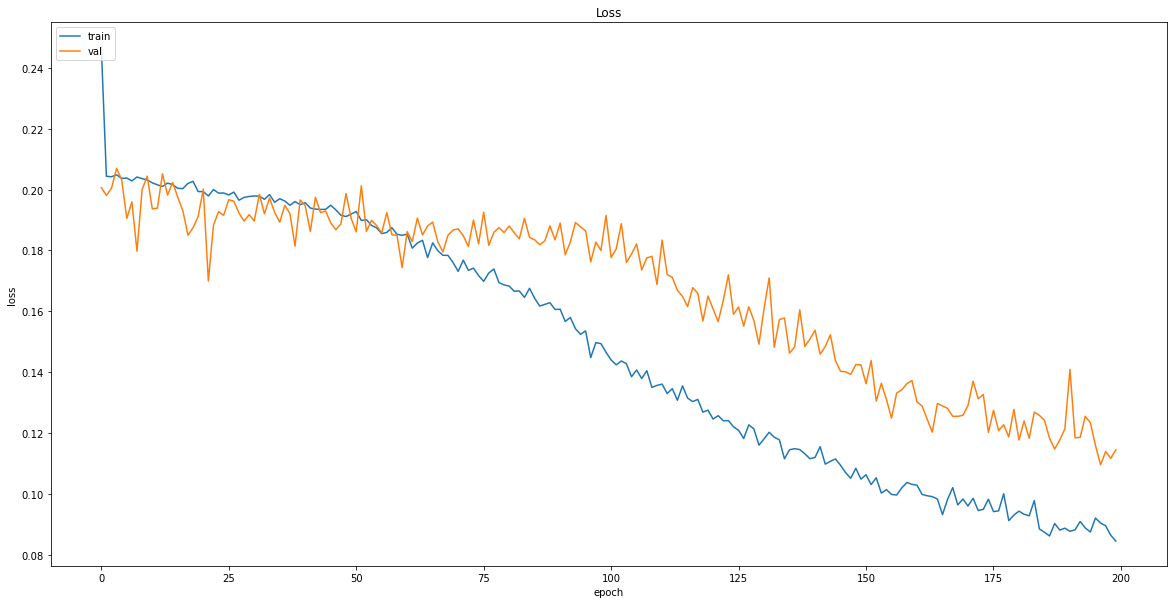

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [145]:
# Save model
model.save("models/{}".format('wmt_image_cnn_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/wmt_image_cnn_buy_hold_sell_25.model\assets


### Test Performance

#### Non-Recession

In [146]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-06,95.809998,97.317381,-74.593506,126209000.0,2.0
2018-12-07,94.769997,96.925476,-82.783532,115841800.0,2.0
2018-12-10,93.190002,96.350788,-89.635777,107345300.0,2.0
2018-12-11,93.940002,95.979897,-77.930950,114622200.0,2.0
2018-12-12,93.849998,95.652221,-79.172384,108169700.0,2.0


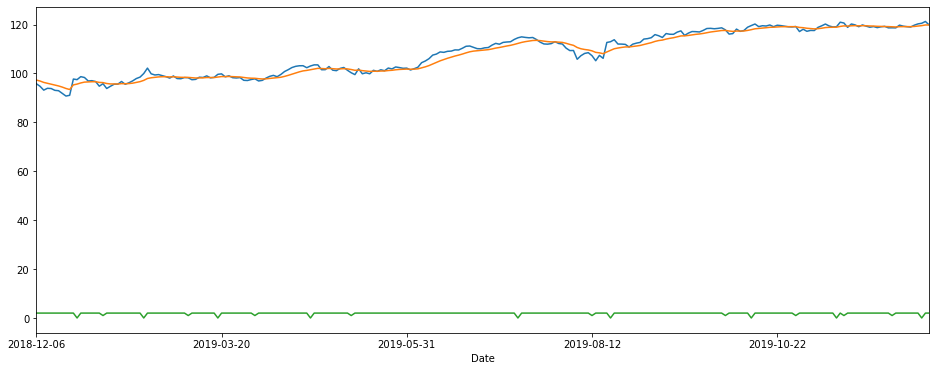

In [147]:
#%matplotlib notebook
df2['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df2['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df2['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [148]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [149]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [150]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [151]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [152]:
model = tf.keras.models.load_model("models/wmt_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 19ms/step - loss: 0.1082 - accuracy: 0.8165 - mean_squared_error: 2.1698 - weighted_accuracy: 0.8165 - weighted_mean_squared_error: 2.1698
Test loss: 0.10822176188230515
Test accuracy: 0.8165137767791748


In [153]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 191, 0: 22, 1: 5})

In [154]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [155]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-155-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-155-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-155-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,2,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,2,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,2,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,0,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,2,2


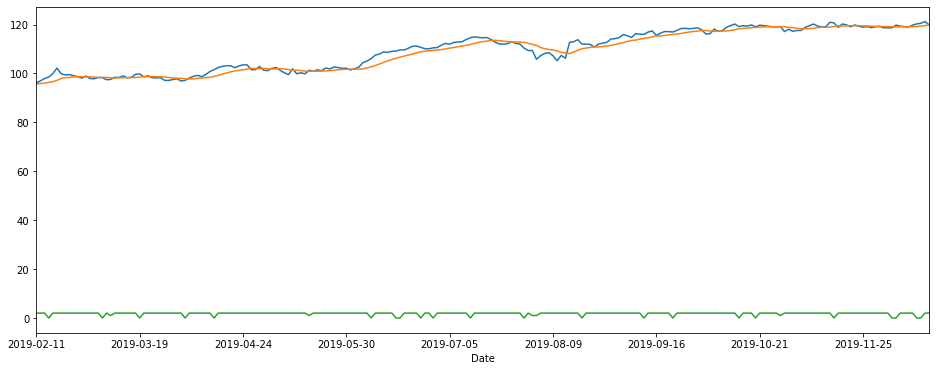

In [156]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

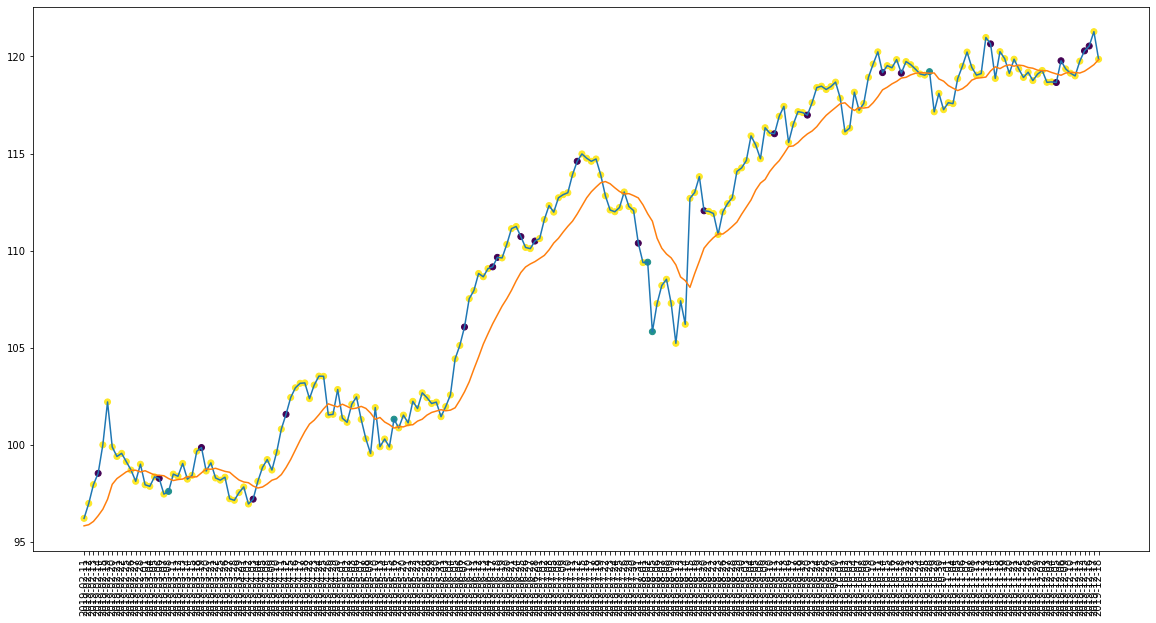

In [157]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

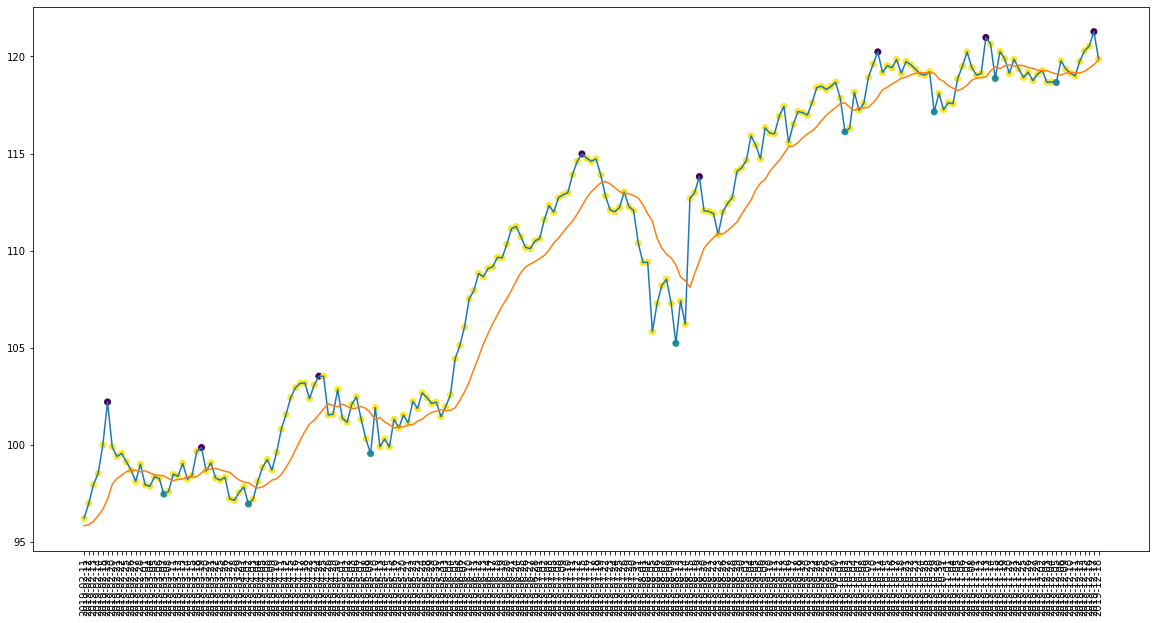

In [158]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [159]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 5
actual holds but predicted sell: 20
actual predicted holds: 177
Percentage buys correct: 0.0%
Percentage sells correct: 12.5%
Percentage holds correct: 87.62376237623762%
actual buys: 8
actual sells: 8
actual holds: 202


In [160]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 40.0%
Percentage sells correct: 40.90909090909091%
Percentage holds correct: 85.78947368421052%


In [161]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $97.58999633789062
Shares owned at the moment: 102
Cash capital at the moment: $18.446379562377842


Price increase from previously bought: 8.381121440113692%
Share price: $106.05999755859376
Shares owned at the moment: 0
Cash capital at the moment: $10806.816301223756


Share price: $109.4000015258789
Shares owned at the moment: 98
Cash capital at the moment: $56.13285127639938


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10397.974331451418


Share price: $105.81999969482422
Shares owned at the moment: 97
Cash capital at the moment: $105.20687613487462


Price increase from previously bought: 5.5969674162452465%
Share price: $112.0500030517578
Shares owned at the moment: 0
Cash capital at the moment: $10944.167833841324


Share price: $119.22000122070312
Shares owned at the moment: 91
Cash capital at the moment: $65.31291745185808




Capital at the end of test period: $10942.57800784111
profit gained:

In [162]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


### Recession

In [163]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-06,118.660004,119.033405,-65.362993,215298600.0,2.0
2019-12-09,119.779999,119.148266,-31.594276,219639400.0,2.0
2019-12-10,119.360001,119.180840,-36.601335,214823400.0,2.0
2019-12-11,119.139999,119.174557,-43.790905,210541100.0,2.0
2019-12-12,119.000000,119.147702,-45.138918,207034700.0,2.0


In [164]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [166]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [167]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [168]:
model = tf.keras.models.load_model("models/wmt_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 8ms/step - loss: 0.1061 - accuracy: 0.8311 - mean_squared_error: 2.1700 - weighted_accuracy: 0.8311 - weighted_mean_squared_error: 2.1700
Test loss: 0.10611023753881454
Test accuracy: 0.8310502171516418


In [169]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 198, 0: 8, 1: 13})

In [170]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [171]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-171-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-171-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-171-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,2,0


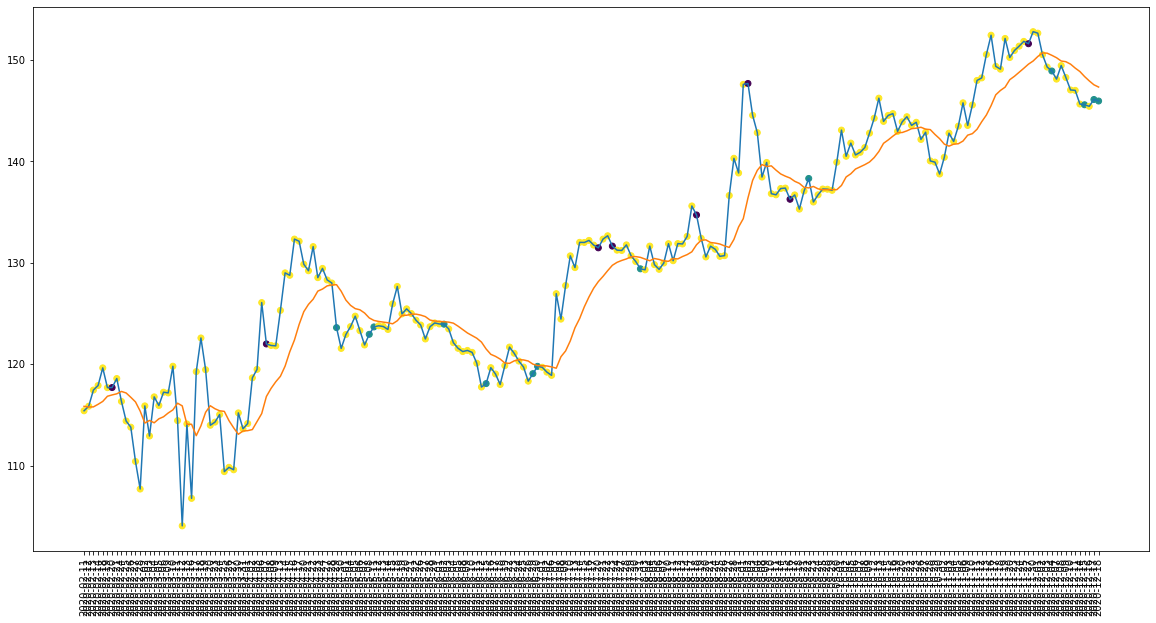

In [172]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

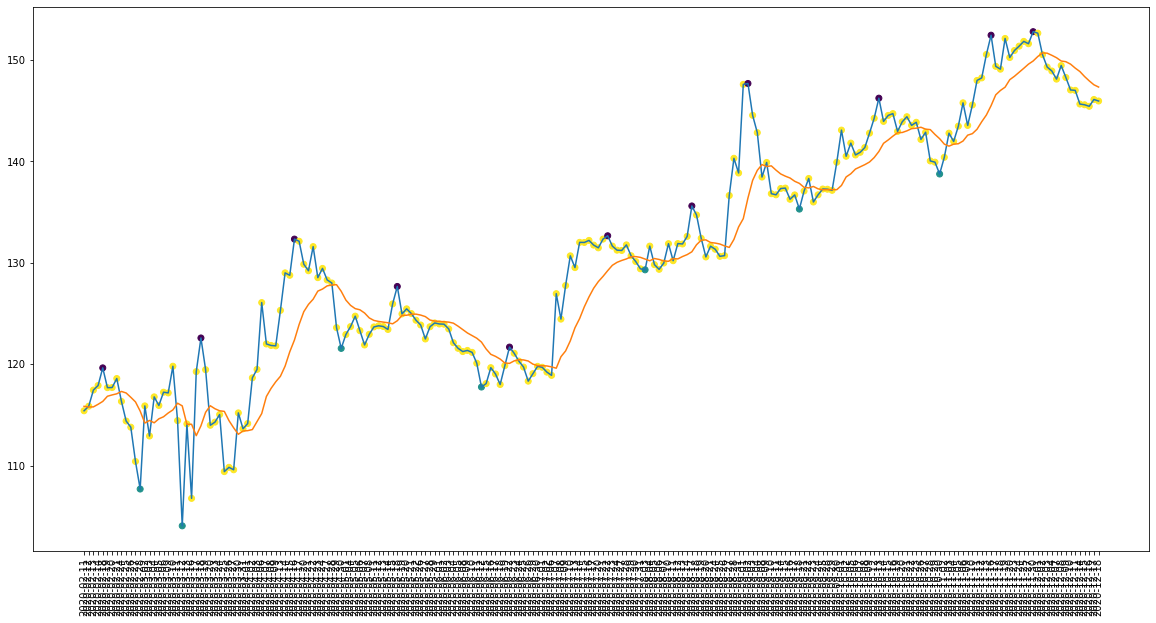

In [173]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [174]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 13
actual holds but predicted sell: 7
actual predicted holds: 181
Percentage buys correct: 0.0%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 90.04975124378109%
actual buys: 7
actual sells: 11
actual holds: 201


In [175]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 61.53846153846154%
Percentage sells correct: 62.5%
Percentage holds correct: 84.77157360406092%


In [176]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $123.5999984741211
Shares owned at the moment: 80
Cash capital at the moment: $84.80812240600608


Stop Loss Activated!

Share price: $120.08999633789062
Shares owned at the moment: 0
Cash capital at the moment: $9665.58803024292


Share price: $118.08000183105469
Shares owned at the moment: 81
Cash capital at the moment: $74.80556151962264


Price increase from previously bought: 11.034424288162725%
Share price: $131.47000122070312
Shares owned at the moment: 0
Cash capital at the moment: $10694.590717624664


Share price: $129.39999389648438
Shares owned at the moment: 82
Cash capital at the moment: $54.611519489288185


Price increase from previously bought: 13.81375070297375%
Share price: $147.67999267578125
Shares owned at the moment: 0
Cash capital at the moment: $12131.069080554962


Share price: $138.30999755859378
Shares owned at the moment: 87
Cash capital at the moment: $65.00862604141003


Price increase from previously bought: 9.308258322808038%
Share price: $

In [177]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


## Fresh Del Monte Produce Inc

In [178]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


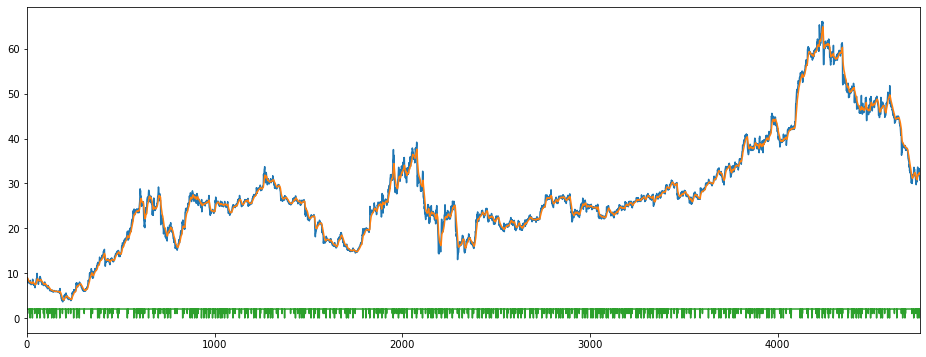

In [179]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [180]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.7500,8.946622,-66.666667,78200.0,2.0
2000-01-24,8.8750,8.935603,-58.333333,99900.0,2.0
2000-01-25,9.0000,8.945511,-50.000000,123600.0,2.0
2000-01-26,8.6875,8.905817,-70.833333,87300.0,2.0
2000-01-27,8.5625,8.852999,-76.000000,32400.0,2.0


In [181]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1

In [182]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [184]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4735, 64, 64, 1)

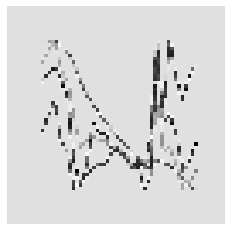

In [185]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [186]:
X = X/255

In [187]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [188]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [189]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [190]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [191]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.298651252408478, 1: 7.215238095238095, 2: 0.3670542635658915}
Epoch 1/200
30/30 [==============================] - 2s 62ms/step - loss: 0.2471 - accuracy: 0.3039 - mse: 1.6383 - weighted_accuracy: 0.3222 - weighted_mse: 1.7493 - val_loss: 0.1955 - val_accuracy: 0.0475 - val_mse: 0.9924 - val_weighted_accuracy: 0.0475 - val_weighted_mse: 0.9924
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2061 - accuracy: 0.3683 - mse: 1.1918 - weighted_accuracy: 0.3257 - weighted_mse: 1.1941 - val_loss: 0.1893 - val_accuracy: 0.8976 - val_mse: 0.9958 - val_weighted_accuracy: 0.8976 - val_weighted_mse: 0.9958
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2046 - accuracy: 0.4044 - mse: 1.1587 - weighted_accuracy: 0.3370 - weighted_mse: 1.1800 - val_loss: 0.1915 - val_accuracy: 0.7254 - val_mse: 1.0196 - val_weighted_accuracy: 0.7254 - val_weighted_mse: 1.0196
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2052 - 

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1899 - accuracy: 0.2730 - mse: 1.2162 - weighted_accuracy: 0.4423 - weighted_mse: 1.1964 - val_loss: 0.1936 - val_accuracy: 0.2439 - val_mse: 1.0261 - val_weighted_accuracy: 0.2439 - val_weighted_mse: 1.0261
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1907 - accuracy: 0.2756 - mse: 1.2221 - weighted_accuracy: 0.4504 - weighted_mse: 1.1886 - val_loss: 0.1965 - val_accuracy: 0.1415 - val_mse: 1.0412 - val_weighted_accuracy: 0.1415 - val_weighted_mse: 1.0412
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1872 - accuracy: 0.2973 - mse: 1.2263 - weighted_accuracy: 0.5021 - weighted_mse: 1.2040 - val_loss: 0.1938 - val_accuracy: 0.2313 - val_mse: 1.0625 - val_weighted_accuracy: 0.2313 - val_weighted_mse: 1.0625
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1892 - accuracy: 0.2790 - mse: 1.2417 - weighted_accuracy: 0.4408 - weig

Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1704 - accuracy: 0.2429 - mse: 1.2907 - weighted_accuracy: 0.5783 - weighted_mse: 1.2489 - val_loss: 0.1938 - val_accuracy: 0.2302 - val_mse: 1.0478 - val_weighted_accuracy: 0.2302 - val_weighted_mse: 1.0478
Epoch 87/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1701 - accuracy: 0.2244 - mse: 1.2923 - weighted_accuracy: 0.5534 - weighted_mse: 1.2883 - val_loss: 0.1946 - val_accuracy: 0.1499 - val_mse: 1.1285 - val_weighted_accuracy: 0.1499 - val_weighted_mse: 1.1285
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1699 - accuracy: 0.2511 - mse: 1.3209 - weighted_accuracy: 0.5616 - weighted_mse: 1.2967 - val_loss: 0.1952 - val_accuracy: 0.1077 - val_mse: 1.2279 - val_weighted_accuracy: 0.1077 - val_weighted_mse: 1.2279
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1719 - accuracy: 0.2223 - mse: 1.2743 - weighted_accuracy: 0.5654 - we

Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1473 - accuracy: 0.3155 - mse: 1.4504 - weighted_accuracy: 0.6232 - weighted_mse: 1.4977 - val_loss: 0.1854 - val_accuracy: 0.3062 - val_mse: 1.2948 - val_weighted_accuracy: 0.3062 - val_weighted_mse: 1.2948
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1433 - accuracy: 0.3369 - mse: 1.4443 - weighted_accuracy: 0.6491 - weighted_mse: 1.5103 - val_loss: 0.1883 - val_accuracy: 0.2714 - val_mse: 1.3034 - val_weighted_accuracy: 0.2714 - val_weighted_mse: 1.3034
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1424 - accuracy: 0.3239 - mse: 1.4847 - weighted_accuracy: 0.6300 - weighted_mse: 1.5414 - val_loss: 0.1846 - val_accuracy: 0.3284 - val_mse: 1.3277 - val_weighted_accuracy: 0.3284 - val_weighted_mse: 1.3277
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1403 - accuracy: 0.3519 - mse: 1.5020 - weighted_accuracy: 0.6548 -

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1229 - accuracy: 0.4847 - mse: 1.7105 - weighted_accuracy: 0.7091 - weighted_mse: 2.0537 - val_loss: 0.1683 - val_accuracy: 0.5216 - val_mse: 1.3204 - val_weighted_accuracy: 0.5216 - val_weighted_mse: 1.3204
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1238 - accuracy: 0.5042 - mse: 1.7174 - weighted_accuracy: 0.7034 - weighted_mse: 2.0651 - val_loss: 0.1616 - val_accuracy: 0.5692 - val_mse: 1.5166 - val_weighted_accuracy: 0.5692 - val_weighted_mse: 1.5166
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1197 - accuracy: 0.5092 - mse: 1.8200 - weighted_accuracy: 0.7199 - weighted_mse: 2.2109 - val_loss: 0.1711 - val_accuracy: 0.5090 - val_mse: 1.5502 - val_weighted_accuracy: 0.5090 - val_weighted_mse: 1.5502
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1184 - accuracy: 0.4905 - mse: 1.8137 - weighted_accuracy: 0.7221 - 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1032 - accuracy: 0.6254 - mse: 2.0128 - weighted_accuracy: 0.7534 - weighted_mse: 2.8364 - val_loss: 0.1433 - val_accuracy: 0.7012 - val_mse: 1.5590 - val_weighted_accuracy: 0.7012 - val_weighted_mse: 1.5590
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1005 - accuracy: 0.6288 - mse: 2.0922 - weighted_accuracy: 0.7893 - weighted_mse: 3.0018 - val_loss: 0.1430 - val_accuracy: 0.6938 - val_mse: 1.7172 - val_weighted_accuracy: 0.6938 - val_weighted_mse: 1.7172
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1066 - accuracy: 0.6312 - mse: 2.0375 - weighted_accuracy: 0.7483 - weighted_mse: 2.8191 - val_loss: 0.1474 - val_accuracy: 0.6727 - val_mse: 1.6894 - val_weighted_accuracy: 0.6727 - val_weighted_mse: 1.6894
Epoch 176/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1029 - accuracy: 0.6362 - mse: 2.1041 - weighted_accuracy: 0.7701 -

In [192]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1335548758506775
Test accuracy: 0.7444561719894409


In [193]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.1302239  -1.2545449   0.03125758]
 [-1.1525296  -1.2266983   0.01331754]
 [-1.7882696  -0.55994815 -0.22034448]
 ...
 [-1.580019   -0.5682415  -0.28467283]
 [-0.80656517 -1.4257208  -0.15590969]
 [-1.3406249  -1.0738288  -0.01357415]]


Counter({2: 760, 0: 33, 1: 154})

In [194]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 860, 0: 43, 1: 44})

In [195]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 947
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 35
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 34
actual holds but predicted buy: 141
actual holds but predicted sell: 28
actual predicted holds: 691
Percentage buys correct: 20.454545454545453%
Percentage sells correct: 11.627906976744185%
Percentage holds correct: 80.34883720930233%
actual buys: 44
actual sells: 43
actual holds: 860


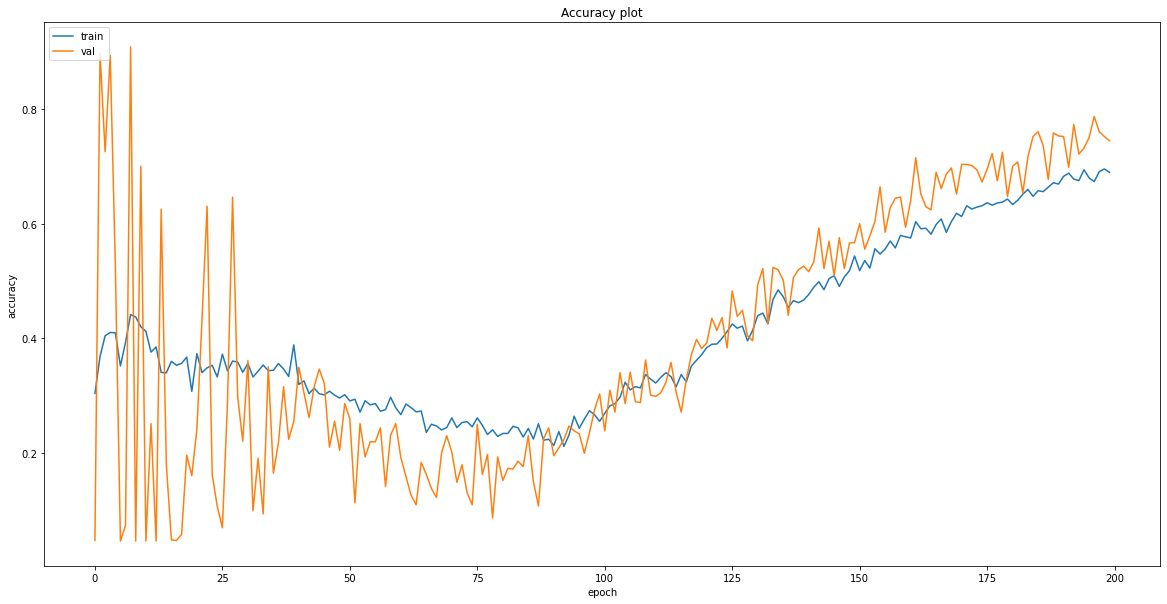

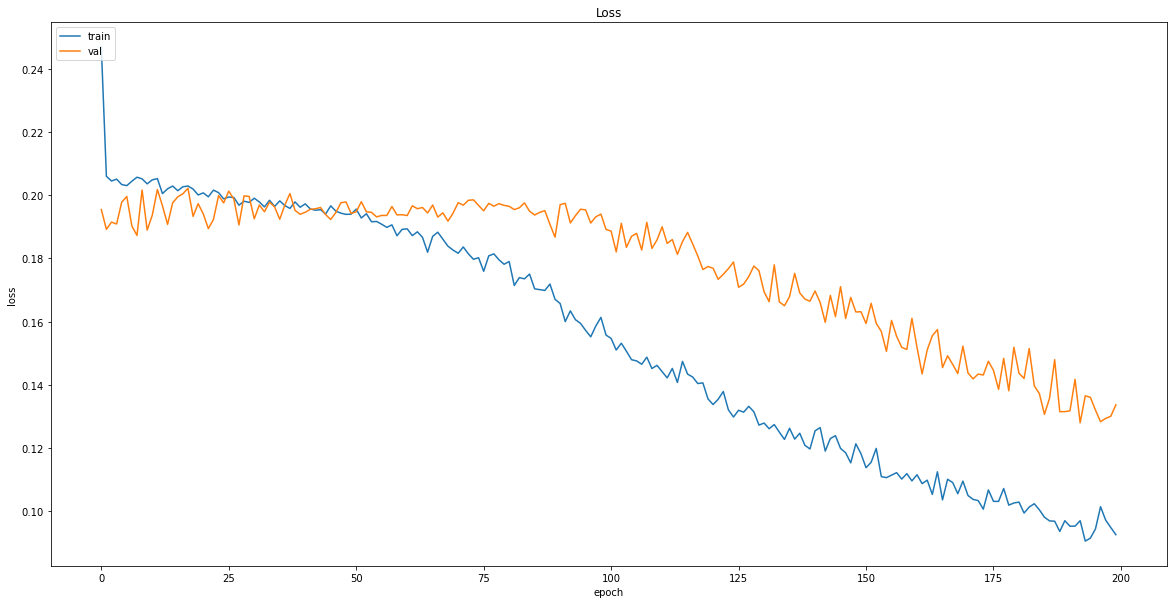

In [196]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [197]:
# Save model
model.save("models/{}".format('FDP_image_cnn_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/FDP_image_cnn_buy_hold_sell_25.model\assets


### Test Performance

### non-recession

In [198]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-06,31.690001,31.948964,-55.603431,41248900.0,2.0
2018-12-07,31.969999,31.952200,-49.568976,41460400.0,2.0
2018-12-10,32.189999,31.988784,-44.827613,41674600.0,2.0
2018-12-11,32.000000,31.990510,-48.922410,41408800.0,2.0
2018-12-12,32.380001,32.050432,-40.732734,41626100.0,2.0


In [199]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [200]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [201]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [202]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [203]:
model = tf.keras.models.load_model("models/FDP_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1334 - accuracy: 0.7523 - mean_squared_error: 1.7584 - weighted_accuracy: 0.7523 - weighted_mean_squared_error: 1.7584
Test loss: 0.13341902196407318
Test accuracy: 0.752293586730957


In [204]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 178, 1: 31, 0: 9})

In [205]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [206]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-206-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-206-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-206-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,2,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,2,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,1,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,0,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,2,0


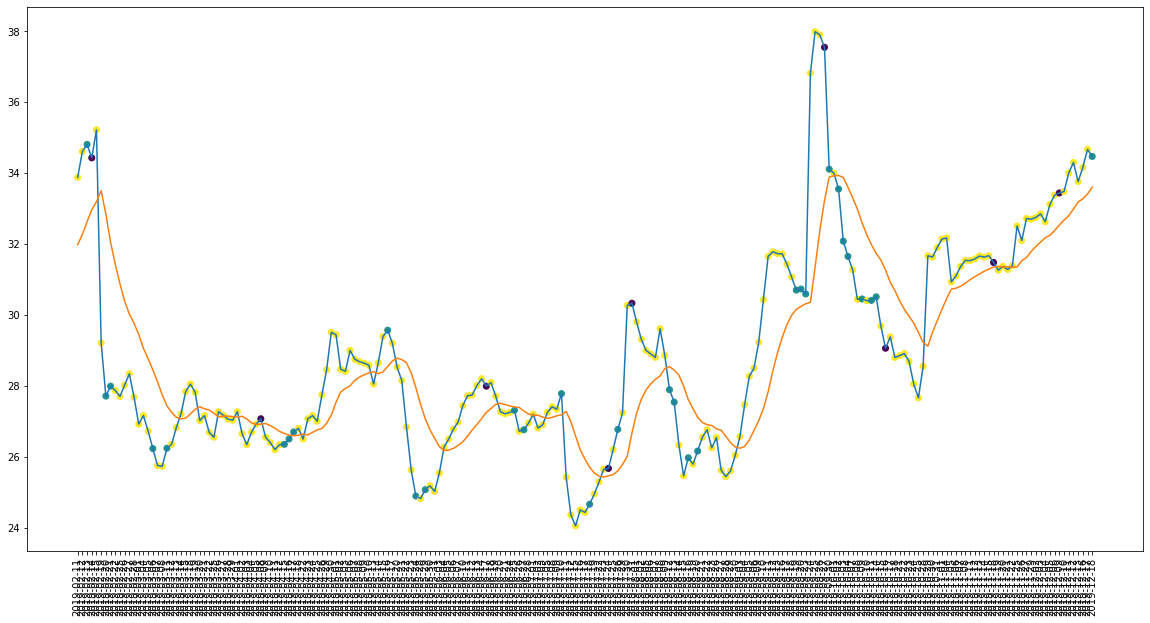

In [207]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

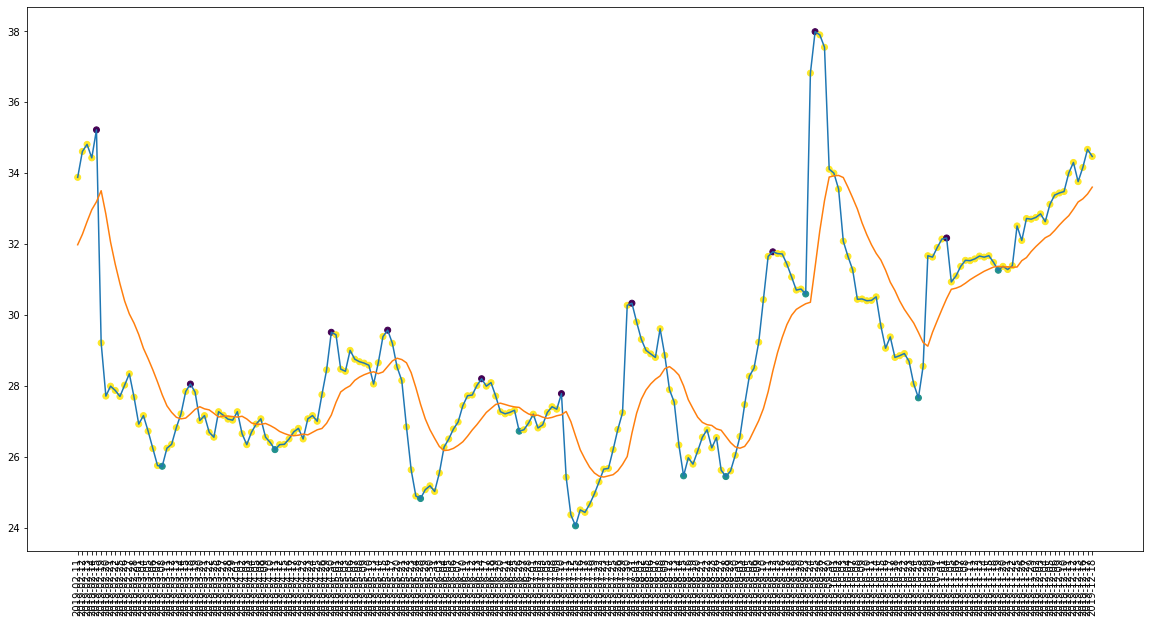

In [208]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [209]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 2
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 28
actual holds but predicted sell: 8
actual predicted holds: 162
Percentage buys correct: 10.0%
Percentage sells correct: 10.0%
Percentage holds correct: 81.81818181818181%
actual buys: 10
actual sells: 10
actual holds: 198


In [210]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 45.16129032258065%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 83.61581920903954%


In [211]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $34.810001373291016
Shares owned at the moment: 286
Cash capital at the moment: $16.961541158676482


Stop Loss Activated!

Share price: $29.209999084472656
Shares owned at the moment: 0
Cash capital at the moment: $8348.047615037918


Share price: $27.709999084472656
Shares owned at the moment: 300
Cash capital at the moment: $12.187140451431333


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $8065.978163276673


Share price: $26.229999542236328
Shares owned at the moment: 306
Cash capital at the moment: $17.5257587375645


Stop Loss Activated!

Share price: $24.88999938964844
Shares owned at the moment: 0
Cash capital at the moment: $7612.920637483598


Share price: $24.88999938964844
Shares owned at the moment: 305
Cash capital at the moment: $0.5943366527553735


Price increase from previously bought: 12.146400361992903%
Share price: $27.989999771118164
Shares owned at the moment: 0
Cash capital at the 

In [212]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


### recession

In [213]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-06,33.119999,32.380699,-4.000007,-5771300.0,2.0
2019-12-09,33.380001,32.534438,-13.261606,-5572400.0,2.0
2019-12-10,33.439999,32.673755,-11.111157,-5391600.0,2.0
2019-12-11,33.480000,32.797793,-10.954105,-5223300.0,2.0
2019-12-12,34.000000,32.982748,-1.298730,-5082700.0,2.0


In [214]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [215]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [216]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [217]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [218]:
model = tf.keras.models.load_model("models/FDP_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1257 - accuracy: 0.7717 - mean_squared_error: 1.7967 - weighted_accuracy: 0.7717 - weighted_mean_squared_error: 1.7967
Test loss: 0.12571172416210175
Test accuracy: 0.7716894745826721


In [219]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 177, 1: 36, 0: 6})

In [220]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [221]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-221-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-221-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-221-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,2,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,2,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,2,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,2,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,2,2


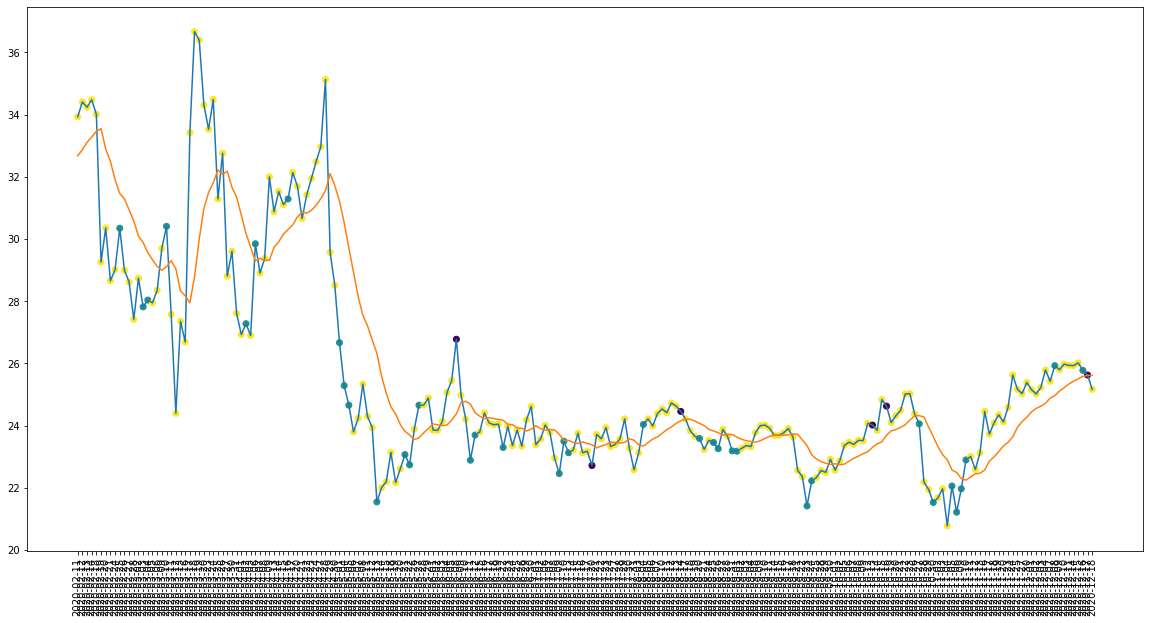

In [222]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

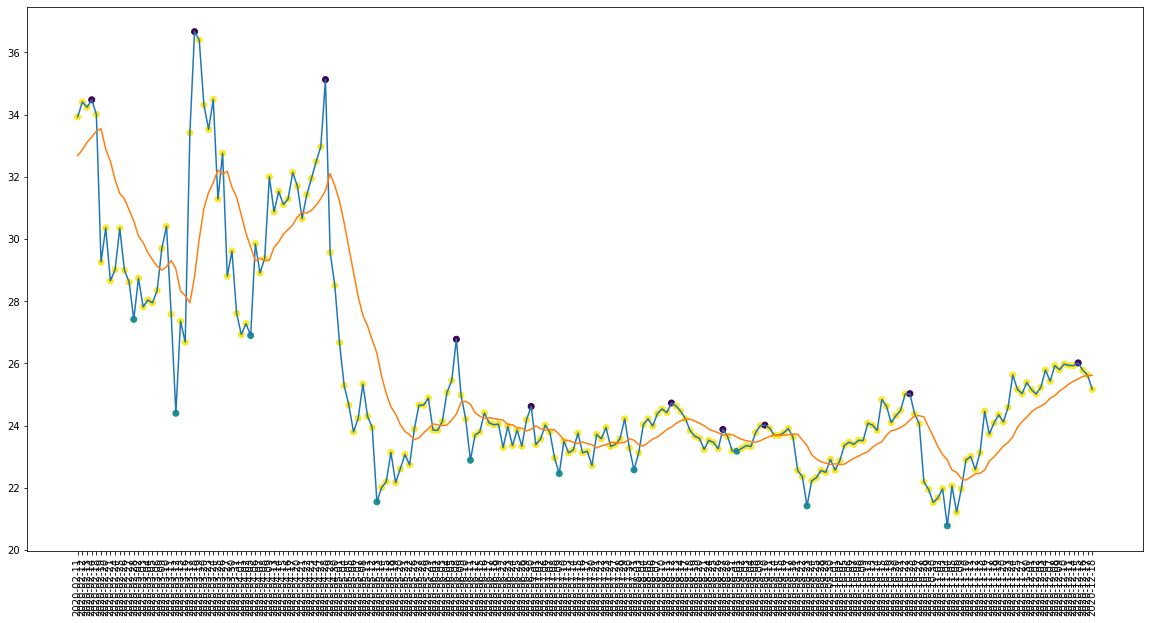

In [223]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [224]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 31
actual holds but predicted sell: 5
actual predicted holds: 163
Percentage buys correct: 50.0%
Percentage sells correct: 10.0%
Percentage holds correct: 81.90954773869346%
actual buys: 10
actual sells: 10
actual holds: 199


In [225]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 63.888888888888886%
Percentage sells correct: 50.0%
Percentage holds correct: 83.52272727272727%


In [226]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $30.35000038146973
Shares owned at the moment: 328
Cash capital at the moment: $17.82417453384187


Stop Loss Activated!

Share price: $29.0
Shares owned at the moment: 0
Cash capital at the moment: $9503.666174533842


Share price: $27.81999969482422
Shares owned at the moment: 340
Cash capital at the moment: $18.85457857894653


Stop Loss Activated!

Share price: $24.399999618530273
Shares owned at the moment: 0
Cash capital at the moment: $8292.040449235914


Share price: $27.28000068664551
Shares owned at the moment: 303
Cash capital at the moment: $3.4691806101764087


Stop Loss Activated!

Share price: $25.290000915527344
Shares owned at the moment: 0
Cash capital at the moment: $7645.266564752098


Share price: $25.290000915527344
Shares owned at the moment: 301
Cash capital at the moment: $12.042490920539421


Stop Loss Activated!

Share price: $23.79999923706055
Shares owned at the moment: 0
Cash capital at the moment: $7156.141811907288


Share price: $21.5499992

In [227]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%
